In [1]:
!pip install lightgbm
!pip install xgboost
!pip install imbalanced-learn


In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay,classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE
le = LabelEncoder()

In [3]:
# Loading datasets
train = pd.read_csv('train.csv')
campaign_data = pd.read_csv('campaign_data.csv')
coupon_item_mapping = pd.read_csv('coupon_item_mapping.csv')
customer_demographics = pd.read_csv('customer_demographics.csv')
customer_transaction_data = pd.read_csv('customer_transaction_data.csv')
item_data = pd.read_csv('item_data.csv')
test = pd.read_csv('test.csv')

Performing Data Pre-Processing, Data Cleaning and Feature Engineering in each DataFrame

In [5]:
#considering train dataframe
train.sample(10)

,id,campaign_id,coupon_id,customer_id,redemption_status
28584,46849,13,450,1488,0
21287,34943,5,1105,763,0
66211,108685,26,1009,1267,0
11966,19771,30,366,9,0
22607,37083,13,253,652,0
38669,63510,10,934,1182,0
16458,27093,30,554,387,0
29539,48409,8,808,1544,0
41117,67512,13,128,545,0
34003,55729,8,711,324,0


In [6]:
train.shape

(78369, 5)

In [7]:
train.dtypes

id                   int64
campaign_id          int64
coupon_id            int64
customer_id          int64
redemption_status    int64
dtype: object

All the datas are of correct datatype

In [9]:
train['redemption_status'].value_counts()

redemption_status
0    77640
1      729
Name: count, dtype: int64

As we can see the data is highly imbalanced. Right now, proceeding with the imabalanced data.

In [11]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

There are no missing values in the train dataframe

In [13]:
#checking for duplicated rows
train.duplicated().sum()

0

There are no duplicate rows in the train dataframe

In [15]:
# considering test dataframe
test.sample(10)

,id,campaign_id,coupon_id,customer_id
45002,115017,18,254,772
21869,56091,18,254,750
1138,2854,22,241,958
35245,90010,23,799,1216
38567,98572,17,781,511
8442,21423,18,477,881
19280,49433,25,1109,911
31641,81064,18,36,557
128,327,22,432,123
23677,60613,18,463,570


In [16]:
test.shape

(50226, 4)

In [17]:
test.dtypes

id             int64
campaign_id    int64
coupon_id      int64
customer_id    int64
dtype: object

All the ids are of correct datatype

In [19]:
test.isnull().sum()

id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64

In [20]:
test.duplicated().sum()

0

In [21]:
test['coupon_id'].value_counts()

coupon_id
869     578
981     478
583     478
744     463
1079    463
       ... 
978      65
874      65
1029     65
1048     65
861      65
Name: count, Length: 331, dtype: int64

Analysing campaign_data

In [23]:
# considering campaign_data dataframe
campaign_data.sample(10)

,campaign_id,campaign_type,start_date,end_date
5,22,X,16/09/13,18/10/13
11,11,Y,22/04/13,07/06/13
26,27,Y,25/08/12,27/10/12
19,5,Y,12/01/13,15/02/13
13,10,Y,08/04/13,10/05/13
2,20,Y,07/09/13,16/11/13
20,4,Y,07/01/13,08/02/13
25,28,Y,16/09/12,16/11/12
18,3,Y,22/12/12,16/02/13
9,16,Y,15/07/13,16/08/13


In [24]:
campaign_data.shape

(28, 4)

In [25]:
campaign_data.dtypes

campaign_id       int64
campaign_type    object
start_date       object
end_date         object
dtype: object

campaign_type represents Anonymised Campaign Type (X/Y), it should be of type category.
start_date and end_date should be coverted to type datetime


In [27]:

campaign_data['campaign_type'] = campaign_data['campaign_type'].astype('category')
campaign_data['start_date'] = pd.to_datetime(campaign_data['start_date'], format='%d/%m/%y')
campaign_data['end_date'] = pd.to_datetime(campaign_data['end_date'], format='%d/%m/%y')


In [28]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,2013-10-21,2013-12-20
1,25,Y,2013-10-21,2013-11-22
2,20,Y,2013-09-07,2013-11-16
3,23,Y,2013-10-08,2013-11-15
4,21,Y,2013-09-16,2013-10-18


In [29]:
campaign_data.dtypes

campaign_id               int64
campaign_type          category
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [30]:
#get a summary of numerical features of the dataset
campaign_data.describe()

,campaign_id,start_date,end_date
count,28.000000,28,28
mean,15.571429,2013-04-03 12:00:00,2013-05-15 08:34:17.142857216
min,1.000000,2012-08-12 00:00:00,2012-09-21 00:00:00
25%,7.750000,2012-12-20 18:00:00,2013-02-02 18:00:00
50%,16.500000,2013-03-25 00:00:00,2013-04-26 00:00:00
75%,23.250000,2013-08-14 00:00:00,2013-09-28 18:00:00
max,30.000000,2013-10-21 00:00:00,2013-12-20 00:00:00
std,9.118271,NaN,NaN


In [31]:
# statistical summary of categorical columns
campaign_data.describe(include="category")

,campaign_type
count,28
unique,2
top,Y
freq,22


From the above analysis, we observe that -:
1. There are 28 rows in campaign_data.
2. In campaign_type feature, Y is the most frequently occuring feature (22 out of 28) and N occurs 6 out of 28 times.
3. There are 28 unique campaign_ids identifying each row uniquely.
4. There no null values in coupon_item_mapping as the number of rows is same as number of count of both coulmns.

In [33]:
campaign_data.duplicated().sum()

0

In [34]:
#getting more information from start_date and end_date
campaign_data['campaign_duration'] = (campaign_data['end_date'] - campaign_data['start_date']).dt.days


campaign_duration represents no.of days the campaign happened

In [36]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,Y,2013-10-21,2013-12-20,60
1,25,Y,2013-10-21,2013-11-22,32
2,20,Y,2013-09-07,2013-11-16,70
3,23,Y,2013-10-08,2013-11-15,38
4,21,Y,2013-09-16,2013-10-18,32


In [37]:
campaign_data.dtypes

campaign_id                   int64
campaign_type              category
start_date           datetime64[ns]
end_date             datetime64[ns]
campaign_duration             int64
dtype: object

In [38]:
#checking if campaign_duration is not zero neither less than 0 for any row
invalid_duration = campaign_data[campaign_data['campaign_duration'] <= 0]
invalid_duration

,campaign_id,campaign_type,start_date,end_date,campaign_duration


Thus, no such row exists where campaign_duration is either 0 or less than 0

In [40]:
#checking null values
campaign_data.isnull().sum()

campaign_id          0
campaign_type        0
start_date           0
end_date             0
campaign_duration    0
dtype: int64

There are no null values present in campaign_data

In [42]:
#checking duplicate rows
campaign_data.duplicated().sum()

0

In [43]:
campaign_data['campaign_type'].isnull().sum()

0

In [44]:
campaign_data['campaign_type'].value_counts()

campaign_type
Y    22
X     6
Name: count, dtype: int64

In [45]:
#applying data transformation, converting Y to 1 and X to 0
campaign_data['campaign_type'] = (
    campaign_data['campaign_type'].map({'Y': 1, 'X': 0})      
)


In [46]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,2013-10-21,2013-12-20,60
1,25,1,2013-10-21,2013-11-22,32
2,20,1,2013-09-07,2013-11-16,70
3,23,1,2013-10-08,2013-11-15,38
4,21,1,2013-09-16,2013-10-18,32


In [47]:
campaign_data.dtypes

campaign_id                   int64
campaign_type              category
start_date           datetime64[ns]
end_date             datetime64[ns]
campaign_duration             int64
dtype: object

In [48]:
campaign_data['campaign_type'] =campaign_data['campaign_type'].astype('int')

In [49]:
campaign_data.dtypes

campaign_id                   int64
campaign_type                 int32
start_date           datetime64[ns]
end_date             datetime64[ns]
campaign_duration             int64
dtype: object

In [50]:
campaign_data['campaign_type'].value_counts()

campaign_type
1    22
0     6
Name: count, dtype: int64

Analysis of coupon_item_mapping

In [52]:
#considering coupon_item_mapping dataframe
coupon_item_mapping.sample(10)

,coupon_id,item_id
7694,981,43989
54326,23,51355
90171,29,67399
77276,29,40218
81655,32,57611
68955,31,48134
54617,23,15842
87498,32,11189
22388,7,43856
12612,827,69808


In [53]:
coupon_item_mapping.shape

(92663, 2)

In [54]:
coupon_item_mapping.dtypes

coupon_id    int64
item_id      int64
dtype: object

Both the ids are of correct datatype int

In [56]:
# statistical summary of categorical columns
coupon_item_mapping.describe()

,coupon_id,item_id
count,92663.000000,92663.000000
mean,155.967387,36508.613071
std,282.991720,21131.312716
min,1.000000,1.000000
25%,22.000000,18255.500000
50%,30.000000,37955.000000
75%,42.000000,54191.500000
max,1116.000000,74061.000000


From the above , we observe that:
1. We have 1,116 different coupons which are linked to 36,289 different items.
2. Among coupon_ids , 32 id occurs more frequently.
3. Among item_ids, 56523 id occurs more frequently.
4. There no null values in coupon_item_mapping as the number of rows is same as number of count of both ids.

In [58]:
coupon_item_mapping.duplicated().sum()

0

Analysis of customer_demographics

In [60]:
#considering customer_demographics dataframe
customer_demographics.sample(10)

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
349,708,36-45,Married,0,3,1,5
579,1203,36-45,Single,0,1,NaN,3
44,84,46-55,NaN,0,1,NaN,8
508,1054,36-45,NaN,0,1,NaN,5
298,595,18-25,NaN,0,2,NaN,2
128,252,70+,Single,0,1,NaN,3
518,1068,46-55,NaN,0,2,NaN,2
735,1521,46-55,Married,0,2,NaN,7
100,197,18-25,NaN,0,4,2,4
406,829,46-55,NaN,0,1,NaN,1


In [61]:
customer_demographics.shape

(760, 7)

In [62]:
customer_demographics.dtypes

customer_id        int64
age_range         object
marital_status    object
rented             int64
family_size       object
no_of_children    object
income_bracket     int64
dtype: object


age-range represents age range of customer family in years , should be converted to category 
marital_status contains two categories: single and married, should be converted to category
rented represents 0 - not rented accommodation, 1 - rented accommodation, should be converted to category
income_bracket is of correct datatype

In [64]:
#converting datatypes
customer_demographics['age_range'] = customer_demographics['age_range'].astype('category')
customer_demographics['marital_status'] = customer_demographics['marital_status'].astype('category')



In [65]:
customer_demographics['family_size'].value_counts()

family_size
2     303
1     248
3     104
5+     57
4      48
Name: count, dtype: int64

As the family_size and no_of_children contains mixed datatype, integers and string, converting it into integer by removing '+ 'sign.

In [67]:
# Convert family_size (handling '+' symbols)
customer_demographics['family_size'] = (
    customer_demographics['family_size']
    .astype(str)  # Ensure string type
    .str.replace(r'\+', '', regex=True)  # Raw string for regex
    .replace('nan', pd.NA)  # Restore NaN if present
    .astype('Int64')  # Nullable integer type
)

# Convert no_of_children (handling '+' and NaN)
customer_demographics['no_of_children'] = (
    customer_demographics['no_of_children']
    .astype(str)
    .str.replace(r'\+', '', regex=True)  # Raw string for regex
    .replace('nan', pd.NA)
    .astype('Int64')
)

In [68]:
customer_demographics['family_size'].value_counts()

family_size
2    303
1    248
3    104
5     57
4     48
Name: count, dtype: Int64

In [69]:
customer_demographics['no_of_children'].value_counts()

no_of_children
1    107
3     60
2     55
Name: count, dtype: Int64

In [70]:
customer_demographics['income_bracket'].value_counts()

income_bracket
5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
12     10
10     10
11      5
Name: count, dtype: int64

In [71]:
customer_demographics.sample(10)

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
434,889,36-45,NaN,0,1,<NA>,4
246,499,36-45,Married,1,2,<NA>,5
93,185,46-55,Single,0,1,<NA>,7
275,550,36-45,NaN,0,1,<NA>,2
23,41,46-55,Single,0,2,<NA>,4
568,1184,46-55,NaN,0,3,1,4
625,1305,46-55,NaN,0,1,<NA>,5
593,1239,36-45,Single,1,1,<NA>,6
628,1316,56-70,Married,0,2,<NA>,8
265,530,46-55,Single,0,3,2,5


In [72]:
customer_demographics.dtypes

customer_id          int64
age_range         category
marital_status    category
rented               int64
family_size          Int64
no_of_children       Int64
income_bracket       int64
dtype: object

In [73]:
#get a summary of numerical features of the dataset
customer_demographics.describe()

,customer_id,rented,family_size,no_of_children,income_bracket
count,760.000000,760.000000,760.0,222.0,760.000000
mean,779.201316,0.053947,2.161842,1.788288,4.715789
std,459.754429,0.226063,1.168929,0.84299,2.258817
min,1.000000,0.000000,1.0,1.0,1.000000
25%,382.750000,0.000000,1.0,1.0,3.000000
50%,774.500000,0.000000,2.0,2.0,5.000000
75%,1187.250000,0.000000,3.0,3.0,6.000000
max,1581.000000,1.000000,5.0,3.0,12.000000


In [74]:
# statistical summary of categorical columns
customer_demographics.describe(include="category")

,age_range,marital_status
count,760,431
unique,6,2
top,46-55,Married
freq,271,317


In [75]:
customer_demographics['income_bracket'].value_counts()

income_bracket
5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
12     10
10     10
11      5
Name: count, dtype: int64

From the above, we observe:
1. There are 760 unique values in customer_id .
2. In age_range, 6 unique ranges are present out of which 46-55 is the most common range in family. 
3. There are null values present in marital_status and no_of_children as the number of count is less than 760 .
4. In family_size, there are 5 unique categories among which 2 is the most common family_size.
5. Thre are 12 unique categories in income_bracket, out of which 5 is the most common, which shows that people with very low income (1,2, 3 ) are less , middle range income people (4,5,6) has more data points and very high income range (7,8,9,10,11,12) are very few.


In [77]:
#checking for missing values as we can see from above they are present in marital_status and  no_of_children
customer_demographics.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [78]:
# checking the missing value percentage
(customer_demographics.isnull().sum()/len(customer_demographics)) * 100

customer_id        0.000000
age_range          0.000000
marital_status    43.289474
rented             0.000000
family_size        0.000000
no_of_children    70.789474
income_bracket     0.000000
dtype: float64

Here, 43% of data in marital_status and around 71% data in no_of_children are missing, which is very huge amount

In [80]:
# Create boolean masks for better readability
single_mask1 = customer_demographics['marital_status'].isna() & (customer_demographics['family_size'] == 1)
single_mask2 = customer_demographics['marital_status'].isna() & (customer_demographics['family_size'] - customer_demographics['no_of_children'] == 1)

married_mask1 = customer_demographics['marital_status'].isna() & (customer_demographics['family_size'] - customer_demographics['no_of_children'] == 2) & customer_demographics['no_of_children'].notna()
married_mask2 = customer_demographics['marital_status'].isna() & customer_demographics['no_of_children'].isna() & (customer_demographics['family_size'] == 2)

# Apply the imputations sequentially
customer_demographics.loc[single_mask1, 'marital_status'] = 'Single'
customer_demographics.loc[single_mask2, 'marital_status'] = 'Single'
customer_demographics.loc[married_mask1, 'marital_status'] = 'Married'
customer_demographics.loc[married_mask2, 'marital_status'] = 'Married'

In [81]:
customer_demographics['marital_status'].isnull().sum()

0

In [82]:
# Filling NaN values for no_of_children

# Married people with family_size == 2 will have 0 children
customer_demographics.loc[pd.isnull(customer_demographics.no_of_children) & 
             (customer_demographics.marital_status == 'Married') & 
             (customer_demographics.family_size == 2), 'no_of_children'] = 0

# Singles with family_size == 2 will have 1 child
customer_demographics.loc[pd.isnull(customer_demographics.no_of_children) & 
             (customer_demographics.marital_status != 'Married') & 
             (customer_demographics.family_size == 2), 'no_of_children'] = 1

# Customers with family size 1 will have zero children
customer_demographics.loc[pd.isnull(customer_demographics.no_of_children) & 
             (customer_demographics.family_size == 1), 'no_of_children'] = 0

# Convert to integer
customer_demographics['no_of_children'] = customer_demographics['no_of_children'].astype(np.int64)

In [83]:
customer_demographics['no_of_children'].value_counts()

no_of_children
0    512
1    133
3     60
2     55
Name: count, dtype: int64

In [84]:
customer_demographics['no_of_children'].isnull().sum()

0

In [85]:
#checking for duplicate rows
customer_demographics.duplicated().sum()

0

In [86]:
#applying data transformation
customer_demographics['marital_status'] = (
    customer_demographics['marital_status'].map({'Married': 1, 'Single': 0}).astype(int)      
)


In [87]:
customer_demographics['marital_status']

0      1
1      1
2      1
3      1
4      0
      ..
755    1
756    1
757    0
758    1
759    1
Name: marital_status, Length: 760, dtype: int32

In [88]:
customer_demographics.dtypes

customer_id          int64
age_range         category
marital_status       int32
rented               int64
family_size          Int64
no_of_children       int64
income_bracket       int64
dtype: object

In [89]:
customer_demographics['age_range']

0        70+
1      46-55
2      26-35
3      26-35
4      46-55
       ...  
755    36-45
756    46-55
757    46-55
758    26-35
759    26-35
Name: age_range, Length: 760, dtype: category
Categories (6, object): ['18-25', '26-35', '36-45', '46-55', '56-70', '70+']

In [90]:
#applying data transformation, changing age_range with their mid points,for 70+ - assuming a random value
age_mapping = {
    '18-25': 21.5,
    '26-35': 30.5,
    '36-45': 40.5,
    '46-55': 50.5,
    '56-70': 63.0,
    '70+': 75.0  
}
customer_demographics['age_numeric'] =customer_demographics['age_range'].map(age_mapping).astype(float)

In [91]:
customer_demographics.dtypes

customer_id          int64
age_range         category
marital_status       int32
rented               int64
family_size          Int64
no_of_children       int64
income_bracket       int64
age_numeric        float64
dtype: object

In [92]:
customer_demographics['age_numeric'] 

0      75.0
1      50.5
2      30.5
3      30.5
4      50.5
       ... 
755    40.5
756    50.5
757    50.5
758    30.5
759    30.5
Name: age_numeric, Length: 760, dtype: float64

In [93]:
customer_demographics.drop(columns=['age_range'], inplace=True)

Analysis of customer_transaction_data

In [95]:
#considering customer_transaction_data dataframe
customer_transaction_data.sample(10)

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
649968,2012-11-02,1323,15111,2,74.80,0.00,0.0
1212627,2013-05-22,787,17983,1,106.50,-35.62,0.0
468235,2012-08-30,1536,34436,1,45.95,0.00,0.0
300371,2012-06-27,1390,24485,1,66.97,-64.47,0.0
1314929,2013-06-29,1250,68282,1,81.57,-7.12,0.0
1074525,2013-04-01,271,32870,1,88.69,0.00,0.0
237998,2012-06-03,136,26755,1,81.57,0.00,0.0
382853,2012-07-26,167,5122,1,28.14,-3.56,0.0
768132,2012-12-13,1157,45096,1,117.19,0.00,0.0
1036621,2013-03-18,811,11113,1,88.69,0.00,0.0


In [96]:
customer_transaction_data.shape

(1324566, 7)

In [97]:
#checking for datatypes of each column
customer_transaction_data.dtypes

date                object
customer_id          int64
item_id              int64
quantity             int64
selling_price      float64
other_discount     float64
coupon_discount    float64
dtype: object

date should be coverted to datetime datatype . 

rest of the coulmn's datatype is correct

In [99]:
customer_transaction_data['date'] = pd.to_datetime(customer_transaction_data['date'])


In [100]:
customer_transaction_data.dtypes

date               datetime64[ns]
customer_id                 int64
item_id                     int64
quantity                    int64
selling_price             float64
other_discount            float64
coupon_discount           float64
dtype: object

In [101]:
#checking for duplicate rows
customer_transaction_data.duplicated().sum()

2916

In [102]:
#printing duplicate rows along with all of the occurences
duplicate_rows = customer_transaction_data[customer_transaction_data.duplicated(keep=False)]
duplicate_rows

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
5463,2012-01-19,801,32650,3,213.72,-159.22,0.00
5465,2012-01-19,801,32650,3,213.72,-159.22,0.00
5491,2012-01-19,814,25251,2,163.14,0.00,0.00
5493,2012-01-19,814,57670,2,21.37,0.00,0.00
5497,2012-01-19,814,25251,2,163.14,0.00,0.00
...,...,...,...,...,...,...,...
1323178,2013-07-03,1485,49741,1,142.12,-35.62,-71.24
1323390,2013-07-03,1558,64186,2,71.24,-20.66,-71.24
1323391,2013-07-03,1558,64186,2,71.24,-20.66,-71.24
1323412,2013-07-03,998,18118,2,152.45,0.00,-17.81


Thus, we can observe from above data, that there are 2916 duplicate rows present in customer_transaction_data.

In [104]:
#dropping the duplicate rows
customer_transaction_data.drop_duplicates(inplace=True)

In [105]:
customer_transaction_data.duplicated().sum()

0

In [106]:
#get a summary of numerical features of the dataset
np.round(customer_transaction_data.describe(include=["int64", "float64"]), 2)

,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,1321650.00,1321650.00,1321650.00,1321650.00,1321650.00,1321650.00
mean,803.92,29517.25,130.89,114.57,-17.74,-0.57
std,457.27,17907.28,1312.46,152.73,37.82,7.01
min,1.00,1.00,1.00,0.36,-3120.31,-1992.23
25%,418.00,14683.00,1.00,49.51,-23.15,0.00
50%,801.00,26594.00,1.00,78.01,-1.78,0.00
75%,1197.00,42407.00,1.00,124.31,0.00,0.00
max,1582.00,74066.00,89638.00,17809.64,0.00,0.00


From the above data, we observe:
1. For most of the transactions, quantity is 1 , but few transactions have taken place in large quantity , suggesting bulk purchase.
2. Most of the transactions have taken place without applying any coupon_discount.
3. For the other_discount, median is -1.78 , also as 75 percentile is 0, shows most of the transactions have taken place without applying any other_discount.
4. There are 1582 unique customer ids who looks for buying 74063 unique items.

In [108]:
#Creating 3 new columns from the date column
customer_transaction_data['day'] = customer_transaction_data["date"].apply(lambda x: x.day)
customer_transaction_data['dow'] = customer_transaction_data["date"].apply(lambda x: x.weekday())
customer_transaction_data['month'] = customer_transaction_data["date"].apply(lambda x: x.month)

In [109]:
# Convert transaction-level values to per-unit values  
customer_transaction_data['selling_price'] = customer_transaction_data['selling_price'] / customer_transaction_data['quantity']  
customer_transaction_data['other_discount'] = customer_transaction_data['other_discount'] / customer_transaction_data['quantity']  

# Calculate final per-unit selling price after discount  
customer_transaction_data['selling_price'] = customer_transaction_data['selling_price'] - customer_transaction_data['other_discount']  

In [110]:
# Inserting a new column to indicate whether a coupon was used (1) or not (0)
customer_transaction_data['coupon_used'] = customer_transaction_data['coupon_discount'].apply(lambda x: 1 if x != 0 else 0)

In [111]:
customer_transaction_data.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month,coupon_used
0,2012-01-02,1501,26830,1,45.95,-10.69,0.0,2,0,1,0
1,2012-01-02,1501,54253,1,67.32,-13.89,0.0,2,0,1,0
2,2012-01-02,1501,31962,1,120.75,-14.25,0.0,2,0,1,0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,2,0,1,0
4,2012-01-02,1501,48199,1,99.38,-28.14,0.0,2,0,1,0


In [112]:
customer_transaction_data['coupon_used'].value_counts()

coupon_used
0    1301164
1      20486
Name: count, dtype: int64

In [113]:
customer_transaction_data.dtypes

date               datetime64[ns]
customer_id                 int64
item_id                     int64
quantity                    int64
selling_price             float64
other_discount            float64
coupon_discount           float64
day                         int64
dow                         int64
month                       int64
coupon_used                 int64
dtype: object

Thus, the datatype of newly created features are correct.

Analysis of item_data

In [116]:
#considering item_data dataframe
item_data.sample(10)

,item_id,brand,brand_type,category
11197,11198,56,Local,Grocery
10213,10214,686,Established,Pharmaceutical
4509,4510,1,Established,Natural Products
7821,7822,56,Local,Grocery
42797,42798,1429,Established,Grocery
6147,6148,350,Established,Packaged Meat
25114,25115,2149,Established,Grocery
42933,42934,133,Established,Grocery
9290,9291,1587,Established,Grocery
29306,29307,1390,Established,Pharmaceutical


In [117]:
item_data.shape

(74066, 4)

In [118]:
item_data.dtypes

item_id        int64
brand          int64
brand_type    object
category      object
dtype: object


brand represents unique id for item brand, keeping it as int.
brand_type and category should be of type category

In [120]:

item_data['brand_type'] = item_data['brand_type'].astype('category')
item_data['category'] = item_data['category'].astype('category')


In [121]:
item_data.dtypes

item_id          int64
brand            int64
brand_type    category
category      category
dtype: object

In [122]:
#checking for duplicate rows
item_data.duplicated().sum()

0

In [123]:
# statistical summary of categorical columns
item_data.describe(include="category")

,brand_type,category
count,74066,74066
unique,2,19
top,Established,Grocery
freq,62842,32448


From the above data, we observe:
1. There are no null values in any column in item_data.
2. There are 74066 unique ids corresponding to each item_id.
3. brand_type contains 2 different categories but people purchase more from an established brand.
4. From 19 diferent categories of items, grocery is most common.

In [125]:
#applying label encoding
item_data['category'] = le.fit_transform(item_data['category'])

#apply mapping to brand_type, converting Established to 1 and Local to 0
item_data['brand_type'] = (
    item_data['brand_type'].map({'Established': 1, 'Local': 0}).astype(int)      
)


In [126]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,1,6
1,2,1,1,8
2,3,56,0,1
3,4,56,0,6
4,5,56,0,6


In [127]:
item_data.dtypes

item_id       int64
brand         int64
brand_type    int32
category      int32
dtype: object

Merging dataframes

Merging item_data with coupon_item_mapping

In [130]:
coupon_item_data = pd.merge(coupon_item_mapping, item_data, on="item_id", how="left")

In [131]:
coupon_item_data.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,0,6
1,107,75,56,0,6
2,494,76,209,1,6
3,522,77,278,1,6
4,518,77,278,1,6


In [132]:
coupon_item_data.shape

(92663, 5)

Aggregating customer_transaction_data by item_id

In [134]:
# Aggregate transactions by item_id (mean aggregation)
mean_transaction = pd.pivot_table(
    customer_transaction_data,
    index="item_id",
    values=['customer_id', 'quantity', 'selling_price', 'other_discount', 'coupon_discount', 'coupon_used'],
    aggfunc={
        'customer_id': lambda x: x.nunique(),  # Better way to count unique customers
        'quantity': 'mean',
        'selling_price': 'mean',
        'other_discount': 'mean',
        'coupon_discount': 'mean',
        'coupon_used': 'sum'  
    },
    observed=True  
).reset_index().rename(columns={'customer_id': 'no_of_customers'})# Renaming column customer_id




In [135]:
mean_transaction.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price
0,1,0.0,0,2,0.0,1.0,124.31
1,2,0.0,0,1,0.0,1.0,35.26
2,3,0.0,0,1,0.0,1.0,56.64
3,4,0.0,0,1,0.0,1.0,54.85
4,5,0.0,0,1,0.0,1.0,81.57


In [136]:
# Aggregate transactions by item_id (sum aggregation)
sum_transaction = pd.pivot_table(
    customer_transaction_data,
    index="item_id",
    values=['customer_id', 'quantity', 'selling_price', 'other_discount', 'coupon_discount'],
    aggfunc={
        'customer_id': 'count',  # Total transactions per item
        'quantity': 'sum',
        'selling_price': 'sum',
        'other_discount': 'sum',
        'coupon_discount': 'sum'
    },
      observed=False
).reset_index().rename(columns={
    'customer_id': 'total_customer_counts',
    'quantity': 'quantity_sum',
    'selling_price': 'price_sum',
    'other_discount': 'other_discount_sum',
    'coupon_discount': 'coupon_discount_sum'
})

In [137]:
sum_transaction.head()

,item_id,coupon_discount_sum,total_customer_counts,other_discount_sum,quantity_sum,price_sum
0,1,0.0,2,0.0,2,248.62
1,2,0.0,1,0.0,1,35.26
2,3,0.0,1,0.0,1,56.64
3,4,0.0,1,0.0,1,54.85
4,5,0.0,1,0.0,1,81.57


In [138]:
#merging the aggregated transactions data
aggregated_transaction = pd.merge(mean_transaction, sum_transaction, on='item_id',how='left' )

In [139]:
aggregated_transaction.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,coupon_discount_sum,total_customer_counts,other_discount_sum,quantity_sum,price_sum
0,1,0.0,0,2,0.0,1.0,124.31,0.0,2,0.0,2,248.62
1,2,0.0,0,1,0.0,1.0,35.26,0.0,1,0.0,1,35.26
2,3,0.0,0,1,0.0,1.0,56.64,0.0,1,0.0,1,56.64
3,4,0.0,0,1,0.0,1.0,54.85,0.0,1,0.0,1,54.85
4,5,0.0,0,1,0.0,1.0,81.57,0.0,1,0.0,1,81.57


In [140]:
#creating new column for total sum discount
aggregated_transaction['total_discount_sum'] =  aggregated_transaction['coupon_discount_sum'] + aggregated_transaction['other_discount_sum']
#creating new column for total mean discount
aggregated_transaction['total_discount_mean'] = aggregated_transaction['coupon_discount'] + aggregated_transaction['other_discount']


In [141]:
aggregated_transaction.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,coupon_discount_sum,total_customer_counts,other_discount_sum,quantity_sum,price_sum,total_discount_sum,total_discount_mean
0,1,0.0,0,2,0.0,1.0,124.31,0.0,2,0.0,2,248.62,0.0,0.0
1,2,0.0,0,1,0.0,1.0,35.26,0.0,1,0.0,1,35.26,0.0,0.0
2,3,0.0,0,1,0.0,1.0,56.64,0.0,1,0.0,1,56.64,0.0,0.0
3,4,0.0,0,1,0.0,1.0,54.85,0.0,1,0.0,1,54.85,0.0,0.0
4,5,0.0,0,1,0.0,1.0,81.57,0.0,1,0.0,1,81.57,0.0,0.0


In [142]:
aggregated_transaction.shape

(74063, 14)

In [143]:
#merging coupon_item_data with aggregated_transaction based on item_id
coupon_item_transaction = pd.merge(coupon_item_data, aggregated_transaction, on='item_id', how='left')

In [144]:
coupon_item_transaction.head()

,coupon_id,item_id,brand,brand_type,category,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,coupon_discount_sum,total_customer_counts,other_discount_sum,quantity_sum,price_sum,total_discount_sum,total_discount_mean
0,105,37,56,0,6,0.0,0.0,2.0,-8.108333,2.285714,57.247381,0.0,7.0,-56.758333,16.0,400.731667,-56.758333,-8.108333
1,107,75,56,0,6,0.0,0.0,4.0,-2.633712,1.363636,38.828485,0.0,33.0,-86.912500,45.0,1281.340000,-86.912500,-2.633712
2,494,76,209,1,6,0.0,0.0,1.0,-17.450000,1.000000,106.500000,0.0,1.0,-17.450000,1.0,106.500000,-17.450000,-17.450000
3,522,77,278,1,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-33.840000,-16.920000
4,518,77,278,1,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-33.840000,-16.920000


In [145]:
coupon_item_transaction.shape

(92663, 18)

In [146]:
coupon_item_transaction.dtypes

coupon_id                  int64
item_id                    int64
brand                      int64
brand_type                 int32
category                   int32
coupon_discount          float64
coupon_used              float64
no_of_customers          float64
other_discount           float64
quantity                 float64
selling_price            float64
coupon_discount_sum      float64
total_customer_counts    float64
other_discount_sum       float64
quantity_sum             float64
price_sum                float64
total_discount_sum       float64
total_discount_mean      float64
dtype: object

In [147]:
#checking for null values
coupon_item_transaction.isnull().sum()

coupon_id                0
item_id                  0
brand                    0
brand_type               0
category                 0
coupon_discount          8
coupon_used              8
no_of_customers          8
other_discount           8
quantity                 8
selling_price            8
coupon_discount_sum      8
total_customer_counts    8
other_discount_sum       8
quantity_sum             8
price_sum                8
total_discount_sum       8
total_discount_mean      8
dtype: int64

As there are only 8 rows out of 92,663 rows which contains null values, so removing them

In [149]:
coupon_item_transaction= coupon_item_transaction.dropna()

In [150]:
coupon_item_transaction.isnull().sum()

coupon_id                0
item_id                  0
brand                    0
brand_type               0
category                 0
coupon_discount          0
coupon_used              0
no_of_customers          0
other_discount           0
quantity                 0
selling_price            0
coupon_discount_sum      0
total_customer_counts    0
other_discount_sum       0
quantity_sum             0
price_sum                0
total_discount_sum       0
total_discount_mean      0
dtype: int64

In [151]:
coupon_item_transaction['no_of_customers']=coupon_item_transaction['no_of_customers'].astype(int)

In [152]:
#aggreagating coupon_item_transaction based on coupon_id
coupon_data = pd.pivot_table(
    coupon_item_transaction,
    index="coupon_id",
    values=['item_id', 'brand', 'brand_type', 'category', 'coupon_discount', 
            'coupon_used', 'no_of_customers', 'other_discount', 'quantity',
            'selling_price', 'coupon_discount_sum', 'total_customer_counts', 
            'other_discount_sum', 'quantity_sum', 'price_sum', 
            'total_discount_mean', 'total_discount_sum'],
    aggfunc={
        'item_id': 'nunique', 
        'brand': lambda x: x.mode()[0],   
        'brand_type': lambda x: x.mode()[0],
        'category': lambda x: x.mode()[0],
        'coupon_discount': 'mean',
        'no_of_customers': 'mean',
        'other_discount': 'mean',
        'quantity': 'mean',
        'selling_price': 'mean',
        'coupon_used': 'sum',
        'coupon_discount_sum': 'sum',
        'total_customer_counts': 'sum',
        'other_discount_sum': 'sum',
        'quantity_sum': 'sum',
        'price_sum': 'sum',
        'total_discount_mean': 'mean',
        'total_discount_sum': 'sum'
    },
    observed=True
).reset_index().rename(columns={'item_id':'data_of_items'})

In [153]:
coupon_data.head()

,coupon_id,brand,brand_type,category,coupon_discount,coupon_discount_sum,coupon_used,data_of_items,no_of_customers,other_discount,other_discount_sum,price_sum,quantity,quantity_sum,selling_price,total_customer_counts,total_discount_mean,total_discount_sum
0,1,1475,1,9,-1.119234,-1095.31,25.0,39,14.794872,-16.547957,-18550.460833,88649.393333,1.219646,1018.0,100.980451,815.0,-17.667191,-19645.770833
1,2,2084,1,6,0.000000,0.00,0.0,2,15.000000,-21.343885,-1163.521667,8940.520000,1.137500,103.0,122.534500,81.0,-21.343885,-1163.521667
2,3,278,1,6,-2.667646,-543.19,14.0,17,8.588235,-14.790729,-4055.343333,27621.490000,1.121632,247.0,131.655894,211.0,-17.458375,-4598.533333
3,4,544,1,6,-1.485152,-881.59,44.0,24,22.333333,-36.718597,-25895.740000,142874.023333,1.020872,702.0,211.708369,676.0,-38.203749,-26777.330000
4,5,5357,1,11,0.000000,0.00,0.0,7,6.000000,-27.265786,-1228.880000,16636.570000,1.000000,44.0,403.970000,44.0,-27.265786,-1228.880000


In [154]:
coupon_data.shape

(1116, 18)

In [155]:
coupon_data.dtypes

coupon_id                  int64
brand                      int64
brand_type                 int32
category                   int32
coupon_discount          float64
coupon_discount_sum      float64
coupon_used              float64
data_of_items              int64
no_of_customers          float64
other_discount           float64
other_discount_sum       float64
price_sum                float64
quantity                 float64
quantity_sum             float64
selling_price            float64
total_customer_counts    float64
total_discount_mean      float64
total_discount_sum       float64
dtype: object

In [156]:
coupon_data.isnull().sum()

coupon_id                0
brand                    0
brand_type               0
category                 0
coupon_discount          0
coupon_discount_sum      0
coupon_used              0
data_of_items            0
no_of_customers          0
other_discount           0
other_discount_sum       0
price_sum                0
quantity                 0
quantity_sum             0
selling_price            0
total_customer_counts    0
total_discount_mean      0
total_discount_sum       0
dtype: int64

In [157]:
#aggregating customer_transaction_data based on customer_id by mean

transactions_customer_mean = pd.pivot_table(
    customer_transaction_data,
    index="customer_id",
    values=['item_id', 'quantity', 'selling_price', 'other_discount', 
            'coupon_discount', 'coupon_used', 'day', 'dow', 'month'],
    aggfunc={
        'item_id': 'nunique', 
        'quantity': 'mean',
        'selling_price': 'mean',
        'other_discount': 'mean',
        'coupon_discount': 'mean',
        'coupon_used': 'sum',
        'day': lambda x: x.mode()[0],  
        'dow': lambda x: x.mode()[0],
        'month': lambda x: x.mode()[0]
    },
    observed=True  # To handle categorical data properly
).reset_index().rename(columns={'item_id': 'no_of_items'})



In [158]:
transactions_customer_mean.head()

,customer_id,coupon_discount,coupon_used,day,dow,no_of_items,month,other_discount,quantity,selling_price
0,1,-1.955631,76,3,3,463,5,-12.750051,1.170172,97.327216
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,107.805783
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,85.082452
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,138.256770
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,115.482842


In [159]:
#aggregating customer_transaction_data based on customer_id by sum
transactions_customer_sum = pd.pivot_table(
    customer_transaction_data,
    index="customer_id",
    values=['item_id', 'quantity', 'selling_price', 'other_discount', 'coupon_discount'],
    aggfunc={
        'item_id': 'count',       # Count of transactions per customer
        'quantity': 'sum',        # Total quantity purchased
        'selling_price': 'sum',   # Total spending
        'other_discount': 'sum',  # Total other discounts
        'coupon_discount': 'sum'  # Total coupon discounts
    },
    observed=True
).reset_index().rename(columns={
    'item_id': 'transaction_count',
    'quantity': 'total_quantity',
    'selling_price': 'total_spending',
    'other_discount': 'total_other_discount',
    'coupon_discount': 'total_coupon_discount'
})


In [160]:
transactions_customer_sum.head()

,customer_id,total_coupon_discount,transaction_count,total_other_discount,total_quantity,total_spending
0,1,-2045.59,1046,-13336.553833,1224,101804.268000
1,2,-249.34,419,-5628.089833,474,45170.623167
2,3,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-89.05,220,-1954.404333,280,30416.489333
4,5,-90.83,792,-8918.471477,93353,91462.410620


In [161]:
merged_customer_transaction = pd.merge(transactions_customer_mean, transactions_customer_sum, on='customer_id', how='left')

In [162]:
merged_customer_transaction.head()

,customer_id,coupon_discount,coupon_used,day,dow,no_of_items,month,other_discount,quantity,selling_price,total_coupon_discount,transaction_count,total_other_discount,total_quantity,total_spending
0,1,-1.955631,76,3,3,463,5,-12.750051,1.170172,97.327216,-2045.59,1046,-13336.553833,1224,101804.268000
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,107.805783,-249.34,419,-5628.089833,474,45170.623167
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,85.082452,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,138.256770,-89.05,220,-1954.404333,280,30416.489333
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,115.482842,-90.83,792,-8918.471477,93353,91462.410620


In [163]:
#merging coupon_data with train and test data
train =  pd.merge(train, coupon_data, on="coupon_id", how="left")
test =  pd.merge(test, coupon_data, on="coupon_id", how="left")

In [164]:
#merging campaign_data with train and test data
train=  pd.merge(train, campaign_data, on="campaign_id", how="left")
test=  pd.merge(test, campaign_data, on="campaign_id", how="left")

In [165]:
#merging customer_demographics with train and test data
train=  pd.merge(train, customer_demographics, on="customer_id", how="left")
test=  pd.merge(test, customer_demographics, on="customer_id", how="left")

In [166]:
#merging campaign_data with train and test data
train=  pd.merge(train, merged_customer_transaction, on="customer_id", how="left")
test=  pd.merge(test, merged_customer_transaction, on="customer_id", how="left")

In [167]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,brand,brand_type,category,coupon_discount_x,coupon_discount_sum,...,no_of_items,month,other_discount_y,quantity_y,selling_price_y,total_coupon_discount,transaction_count,total_other_discount,total_quantity,total_spending
0,1,13,27,1053,0,1105,1,6,-1.233750,-5221.70,...,208,5,-25.583099,340.487097,163.966826,-89.05,310,-7930.760842,105551,50829.715972
1,2,13,116,48,0,56,0,6,0.000000,0.00,...,244,6,-19.871924,31.619792,188.703939,-1237.79,384,-7630.818702,12142,72462.312434
2,6,9,635,205,0,560,1,11,-2.987321,-605.54,...,533,3,-12.864230,1.392157,112.055027,-2101.20,969,-12465.439143,1349,108581.321349
3,7,13,644,1050,0,611,1,6,-4.452500,-17.81,...,216,8,-12.880868,1.291139,100.896997,-178.10,237,-3052.765833,306,23912.588333
4,9,8,1017,1489,0,1558,1,6,-0.155422,-427.44,...,327,5,-12.264174,247.443060,85.016352,-265.01,562,-6892.466021,139063,47779.189609


In [168]:
train.shape

(78369, 46)

In [169]:
test.head()

,id,campaign_id,coupon_id,customer_id,brand,brand_type,category,coupon_discount_x,coupon_discount_sum,coupon_used_x,...,no_of_items,month,other_discount_y,quantity_y,selling_price_y,total_coupon_discount,transaction_count,total_other_discount,total_quantity,total_spending
0,3,22,869,967,1075,1,6,-0.716722,-1941.26,50.0,...,658,5,-10.601140,12.236029,116.043363,-2040.62,1360,-14417.550230,16641,157818.973491
1,4,20,389,1566,57,1,11,-1.899476,-1154.03,34.0,...,1214,6,-9.849175,106.124014,95.906743,-1489.97,2661,-26208.653622,282396,255207.843989
2,5,22,981,510,1335,1,6,-0.685403,-2375.90,103.0,...,1019,5,-16.906480,111.274065,84.492212,-2087.32,1631,-27574.468936,181488,137806.797597
3,8,25,1069,361,1996,1,6,-0.889644,-1209.18,43.0,...,323,6,-11.656451,38.736475,88.203999,0.00,573,-6679.146538,22196,50540.891161
4,10,17,498,811,209,1,6,-4.832059,-1711.54,83.0,...,720,6,-11.466887,1.312024,85.471197,-89.04,1314,-15067.489333,1724,112309.152583


In [170]:
test.shape

(50226, 45)

Thus, train and test data are merged.

Here x tag comes from data, when I merged train with coupon data and y tag comes when I merged traim data with merged_customer_transaction

So, renaming columns

In [174]:
# columns with suffix x
cols_x = ['coupon_discount_x', 'coupon_used_x', 'other_discount_x', 'quantity_x', 'selling_price_x']

# columns with suffix y
cols_y = ['coupon_discount_y', 'coupon_used_y', 'other_discount_y', 'quantity_y', 'selling_price_y']

train.rename(columns={col: col.replace('_x', '_coupon_data') for col in cols_x}, inplace=True)
train.rename(columns={col: col.replace('_y', '_customer_transaction') for col in cols_y}, inplace=True)

test.rename(columns={col: col.replace('_x', '_coupon_data') for col in cols_x}, inplace=True)
test.rename(columns={col: col.replace('_y', '_customer_transaction') for col in cols_y}, inplace=True)

Lets check null values, they maybe present after merging the datas .

In [176]:
#checking null values in train
train.isnull().sum()

id                                          0
campaign_id                                 0
coupon_id                                   0
customer_id                                 0
redemption_status                           0
brand                                       0
brand_type                                  0
category                                    0
coupon_discount_coupon_data                 0
coupon_discount_sum                         0
coupon_used_coupon_data                     0
data_of_items                               0
no_of_customers                             0
other_discount_coupon_data                  0
other_discount_sum                          0
price_sum                                   0
quantity_coupon_data                        0
quantity_sum                                0
selling_price_coupon_data                   0
total_customer_counts                       0
total_discount_mean                         0
total_discount_sum                

In [177]:
#checking null values in test
test.isnull().sum()

id                                          0
campaign_id                                 0
coupon_id                                   0
customer_id                                 0
brand                                       0
brand_type                                  0
category                                    0
coupon_discount_coupon_data                 0
coupon_discount_sum                         0
coupon_used_coupon_data                     0
data_of_items                               0
no_of_customers                             0
other_discount_coupon_data                  0
other_discount_sum                          0
price_sum                                   0
quantity_coupon_data                        0
quantity_sum                                0
selling_price_coupon_data                   0
total_customer_counts                       0
total_discount_mean                         0
total_discount_sum                          0
campaign_type                     

As we see from above, the null values are present in  marital_status, rented , family_size, no_of_children, income_bracket and age_numeric .
All these columns belong to customer_demographics dataframe

Filling all the null values with mode

In [180]:
def fill_null_values(df):
    """
    This function fills the null values present in a column with the mode value of column present in customer_demographics dataframe
    Input is the dataframe
    Function returns dataframe with filled missing values.

   """
    for col in customer_demographics.columns.tolist()[1:]:
        # filling null value with first mode if multiple mode exists
        mode_value = df[col].mode().iloc[0] 
        # Assign filled values (no inplace)
        df[col] = df[col].fillna(mode_value)
    return df

train = fill_null_values(train)
test = fill_null_values(test)


In [181]:
train.isnull().sum()

id                                      0
campaign_id                             0
coupon_id                               0
customer_id                             0
redemption_status                       0
brand                                   0
brand_type                              0
category                                0
coupon_discount_coupon_data             0
coupon_discount_sum                     0
coupon_used_coupon_data                 0
data_of_items                           0
no_of_customers                         0
other_discount_coupon_data              0
other_discount_sum                      0
price_sum                               0
quantity_coupon_data                    0
quantity_sum                            0
selling_price_coupon_data               0
total_customer_counts                   0
total_discount_mean                     0
total_discount_sum                      0
campaign_type                           0
start_date                        

In [182]:
test.isnull().sum()

id                                      0
campaign_id                             0
coupon_id                               0
customer_id                             0
brand                                   0
brand_type                              0
category                                0
coupon_discount_coupon_data             0
coupon_discount_sum                     0
coupon_used_coupon_data                 0
data_of_items                           0
no_of_customers                         0
other_discount_coupon_data              0
other_discount_sum                      0
price_sum                               0
quantity_coupon_data                    0
quantity_sum                            0
selling_price_coupon_data               0
total_customer_counts                   0
total_discount_mean                     0
total_discount_sum                      0
campaign_type                           0
start_date                              0
end_date                          

In [183]:
train.dtypes

id                                               int64
campaign_id                                      int64
coupon_id                                        int64
customer_id                                      int64
redemption_status                                int64
brand                                            int64
brand_type                                       int32
category                                         int32
coupon_discount_coupon_data                    float64
coupon_discount_sum                            float64
coupon_used_coupon_data                        float64
data_of_items                                    int64
no_of_customers                                float64
other_discount_coupon_data                     float64
other_discount_sum                             float64
price_sum                                      float64
quantity_coupon_data                           float64
quantity_sum                                   float64
selling_pr

In [184]:
train['rented'].value_counts()

rented
0.0    75864
1.0     2505
Name: count, dtype: int64

In [185]:
#As rented column only contains 2 whole numbers 1 and 0, converting it to int
train['rented']=train['rented'].astype(int)
test['rented']=test['rented'].astype(int)

In [186]:
for col in train.select_dtypes(include=["Int64"]).columns:
    train[col] = train[col].astype("int64")
for col in test.select_dtypes(include=["Int64"]).columns:
    test[col] = test[col].astype("int64")

In [187]:
train.dtypes

id                                               int64
campaign_id                                      int64
coupon_id                                        int64
customer_id                                      int64
redemption_status                                int64
brand                                            int64
brand_type                                       int32
category                                         int32
coupon_discount_coupon_data                    float64
coupon_discount_sum                            float64
coupon_used_coupon_data                        float64
data_of_items                                    int64
no_of_customers                                float64
other_discount_coupon_data                     float64
other_discount_sum                             float64
price_sum                                      float64
quantity_coupon_data                           float64
quantity_sum                                   float64
selling_pr

In [188]:
test.dtypes

id                                               int64
campaign_id                                      int64
coupon_id                                        int64
customer_id                                      int64
brand                                            int64
brand_type                                       int32
category                                         int32
coupon_discount_coupon_data                    float64
coupon_discount_sum                            float64
coupon_used_coupon_data                        float64
data_of_items                                    int64
no_of_customers                                float64
other_discount_coupon_data                     float64
other_discount_sum                             float64
price_sum                                      float64
quantity_coupon_data                           float64
quantity_sum                                   float64
selling_price_coupon_data                      float64
total_cust

In [189]:
train['redemption_status'].value_counts()

redemption_status
0    77640
1      729
Name: count, dtype: int64

Exploratory Data Analysis

In [191]:
train.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'brand', 'brand_type', 'category', 'coupon_discount_coupon_data',
       'coupon_discount_sum', 'coupon_used_coupon_data', 'data_of_items',
       'no_of_customers', 'other_discount_coupon_data', 'other_discount_sum',
       'price_sum', 'quantity_coupon_data', 'quantity_sum',
       'selling_price_coupon_data', 'total_customer_counts',
       'total_discount_mean', 'total_discount_sum', 'campaign_type',
       'start_date', 'end_date', 'campaign_duration', 'marital_status',
       'rented', 'family_size', 'no_of_children', 'income_bracket',
       'age_numeric', 'coupon_discount_customer_transaction',
       'coupon_used_customer_transaction', 'day', 'dow', 'no_of_items',
       'month', 'other_discount_customer_transaction',
       'quantity_customer_transaction', 'selling_price_customer_transaction',
       'total_coupon_discount', 'transaction_count', 'total_other_discount',
       'total_quantity',

Univariate Analysis

In [193]:
#plotting each column
cols= ['id', 'campaign_id', 'coupon_id', 'customer_id','coupon_discount_coupon_data',
       'coupon_discount_sum', 'coupon_used_coupon_data',  'data_of_items','other_discount_coupon_data', 'other_discount_sum',
       'price_sum', 'quantity_coupon_data', 'quantity_sum',  'selling_price_coupon_data','total_discount_mean', 'total_discount_sum','coupon_discount_customer_transaction',
       'coupon_used_customer_transaction','other_discount_customer_transaction',
       'quantity_customer_transaction', 'selling_price_customer_transaction', 'total_coupon_discount', 'transaction_count',
       'total_other_discount', 'total_quantity', 'total_spending']

# custom function for easy and efficient analysis of numerical univariate


def UVA_numeric(data, var_group):
    ''' 
    Univariate_Analysis_numeric
    takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.
    
    Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
    '''
    size = len(var_group)
    
    # Determine number of rows and columns for the subplots
    ncols = 2  # Set number of columns to 2
    nrows = (size + 1) // 2  # Calculate number of rows dynamically

    # Create the figure with appropriate size
    plt.figure(figsize=(12, 6 * nrows), dpi=100)

    # Looping for each variable
    for j, i in enumerate(var_group):
        # calculating descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max() - data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()

        # calculating points of standard deviation
        points = mean - st_dev, mean + st_dev

        # Plotting the variable with every information
        plt.subplot(nrows, ncols, j + 1)
        sns.kdeplot(x=data[i], fill=True)
        sns.lineplot(x=points, y=[0, 0], color='black', label="std_dev")
        sns.scatterplot(x=[mini, maxi], y=[0, 0], color='orange', label="min/max")
        sns.scatterplot(x=[mean], y=[0], color='red', label="mean")
        sns.scatterplot(x=[median], y=[0], color='blue', label="median")
        
        plt.xlabel('{}'.format(i), fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.title('within 1 std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format(
            (round(points[0], 2), round(points[1], 2)),
            round(kurt, 2),
            round(skew, 2),
            (round(mini, 2), round(maxi, 2), round(ran, 2)),
            round(mean, 2),
            round(median, 2)
        ), fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()


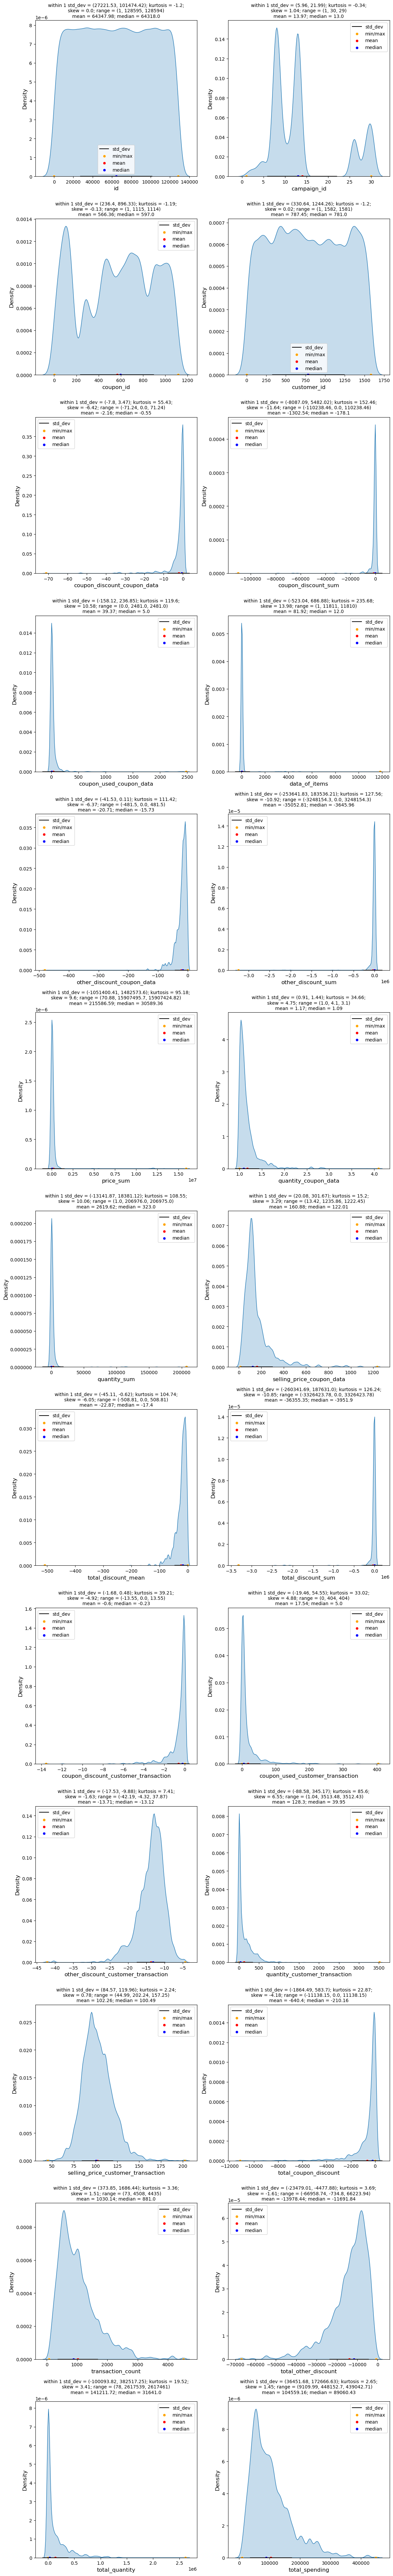

In [194]:
UVA_numeric(train,cols)

1. campaign_id and coupon_id are multimodal graphs, showing that some campaigns are more likely to be visited by customers and some coupons are more likely to be used by customers repectively.
2. The graph for id and customer_id is almost widely spread and almost uniform .Though, in customer_id, some customers are more active than others.
3. The graph for all discount are in negative side as there values are in negative, representing discount . Also , all the discount features are left skewed and contains outliers .
4. Very few customers buy items in large quantity showing bulk purchase .
5. total_spending contains some outliers showing , very few customers does transactions in large amount. It is also right skewed.


Multivariate Analysis

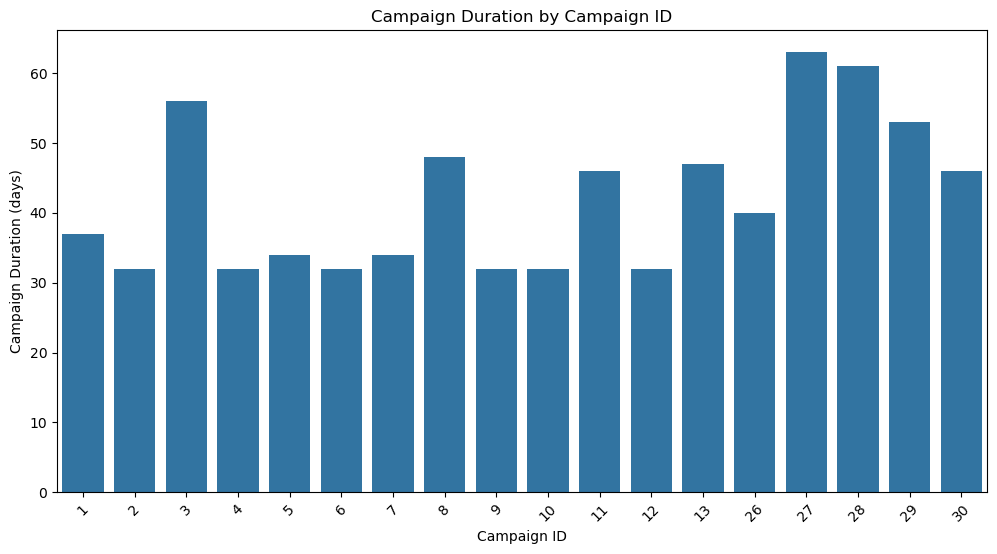

In [197]:
#to see which campaign longed the most
plt.figure(figsize=(12,6))
sns.barplot(data=train, x='campaign_id', y='campaign_duration', errorbar=None)
plt.title('Campaign Duration by Campaign ID')
plt.xlabel('Campaign ID')
plt.ylabel('Campaign Duration (days)')
plt.xticks(rotation=45)
plt.show()

Most of the campiagns last for almost 40 days .
There is one campaign, 27, which last for more than 60 days .


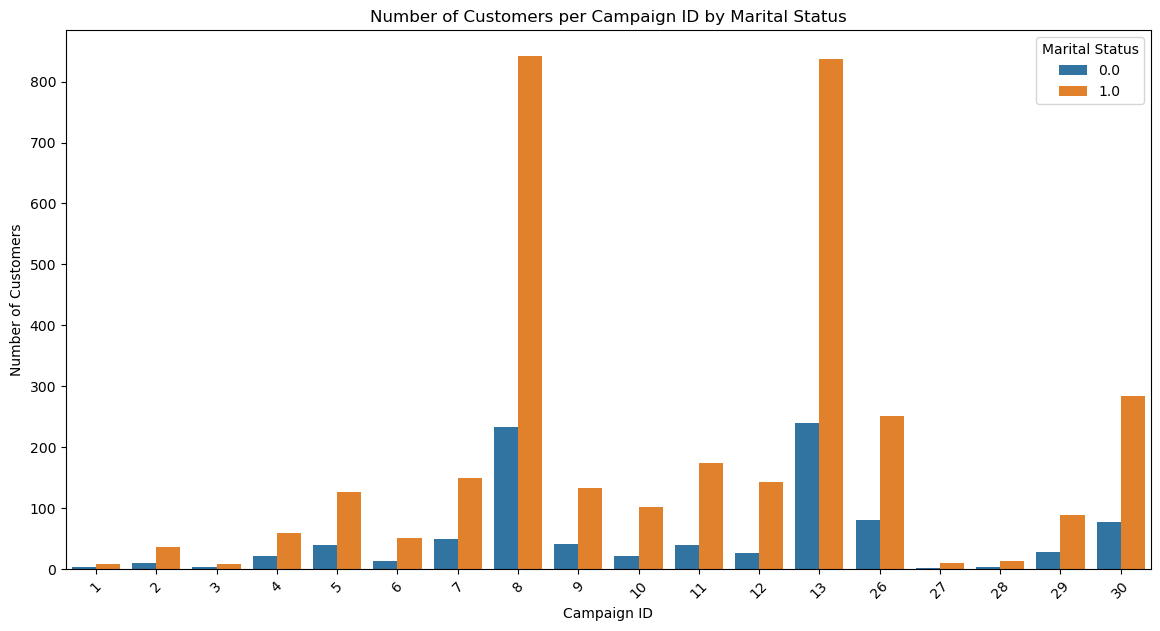

In [199]:
#plotting graph to find no.of customers visited campaign based on their marital status
agg_data = train.groupby(['campaign_id', 'marital_status'])['customer_id'].nunique().reset_index(name='customer_count')

plt.figure(figsize=(14,7))
sns.barplot(data=agg_data, x='campaign_id', y='customer_count', hue='marital_status')
plt.title('Number of Customers per Campaign ID by Marital Status')
plt.xlabel('Campaign ID')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Marital Status')
plt.show()

As per the graph we can say that , married customers have visited campaign more than single customers , and this applicable for all campaigns .
For campaign id 8 and 13, peak is very high showing many customers visit these campaigns often.


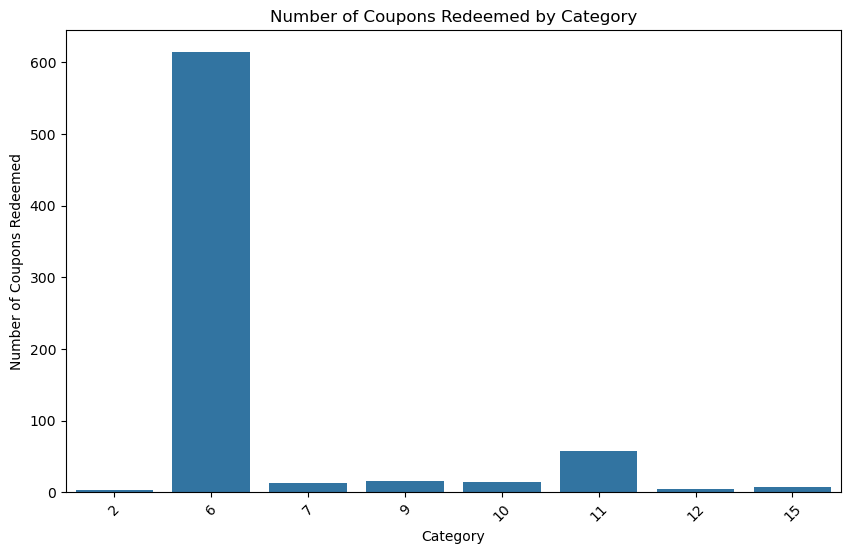

In [201]:
# # finding datas where redemption_status=1 
redeemed = train[train['redemption_status'] == 1]

# no. of coupons redeemed by campaign_id
redeemed_by_category = redeemed.groupby('category')['coupon_id'].count().reset_index(name='redeemed_count')

plt.figure(figsize=(10,6))
sns.barplot(data=redeemed_by_category, x='category', y='redeemed_count')
plt.title('Number of Coupons Redeemed by Category')
plt.xlabel('Category')
plt.ylabel('Number of Coupons Redeemed')
plt.xticks(rotation=45)
plt.show()

In [202]:
#getting 6th category name
original_category = le.inverse_transform([6])
original_category

array(['Grocery'], dtype=object)

Coupon is redeemed most for category 6 (grocery) , showing it is most popular brand category for coupon redemption .

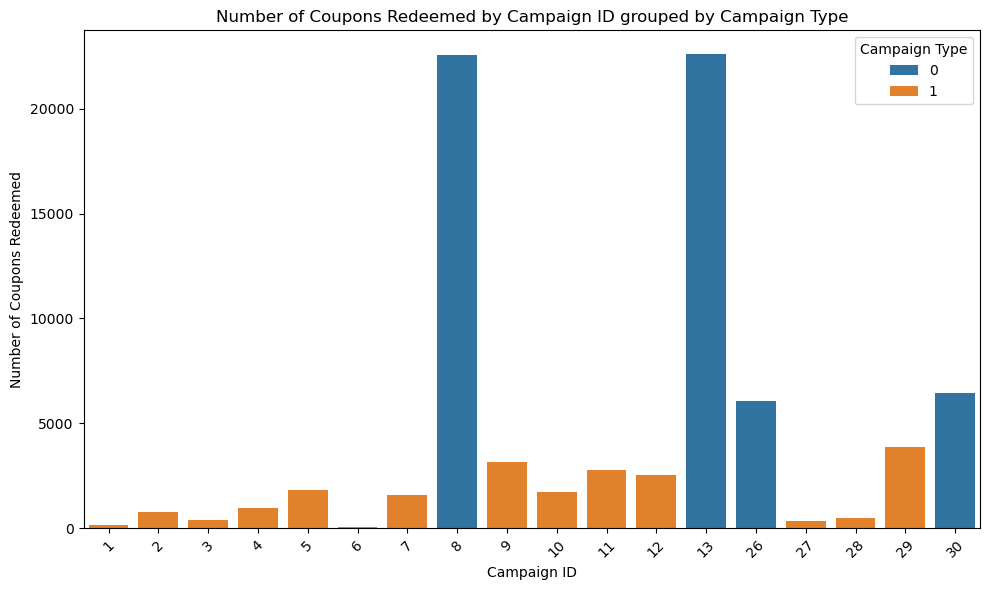

In [204]:
# finding datas where redemption_status=1 
redeemed = train[train['redemption_status'] == 1]
redeemed_by_campaign_type = train.groupby(['campaign_id', 'campaign_type']).size().reset_index(name='redeemed_count')

# plotting Number of Coupons Redeemed by Campaign ID grouped by Campaign Type
plt.figure(figsize=(10,6))
sns.barplot(data=redeemed_by_campaign_type, x='campaign_id', y='redeemed_count', hue='campaign_type')

plt.title('Number of Coupons Redeemed by Campaign ID grouped by Campaign Type')
plt.xlabel('Campaign ID')
plt.ylabel('Number of Coupons Redeemed')
plt.legend(title='Campaign Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The no.of coupons redemmed in X type campaign (0) is higher than campain Y (1).
Campaign id 8 and 13 has higher coupon remeption compared to other ids for campaign type 0 .
For campaign type 1 , campaign id 29, 9 has done more coupon remeption compared to other ids .                                                                   

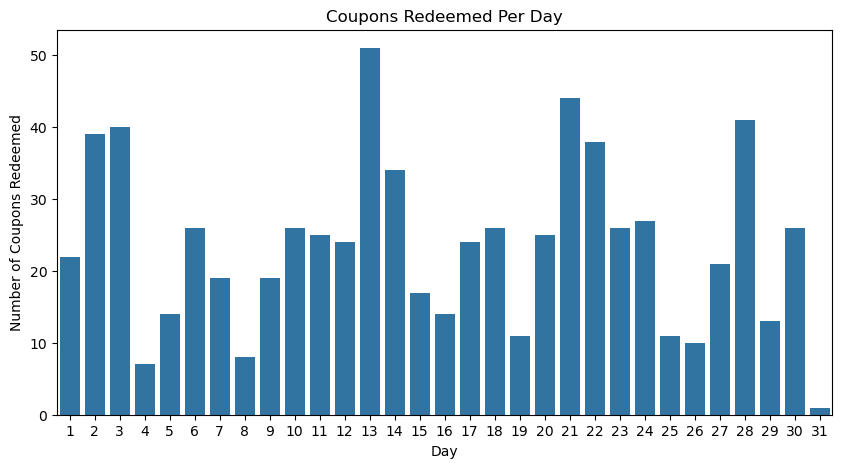

In [206]:
# finding datas where redemption_status=1 
redeemed = train[train['redemption_status'] == 1]

# plotting graph for redeemed coupons per day
redeemed_per_day = redeemed.groupby('day')['coupon_id'].count().reset_index(name='redeemed_count')

plt.figure(figsize=(10,5))
sns.barplot(data=redeemed_per_day, x='day', y='redeemed_count')
plt.title('Coupons Redeemed Per Day')
plt.xlabel('Day')
plt.ylabel('Number of Coupons Redeemed')
plt.show()

The graph shows that coupon redemption is widely spread in the entire month. 
There are some where coupon redemption is high.

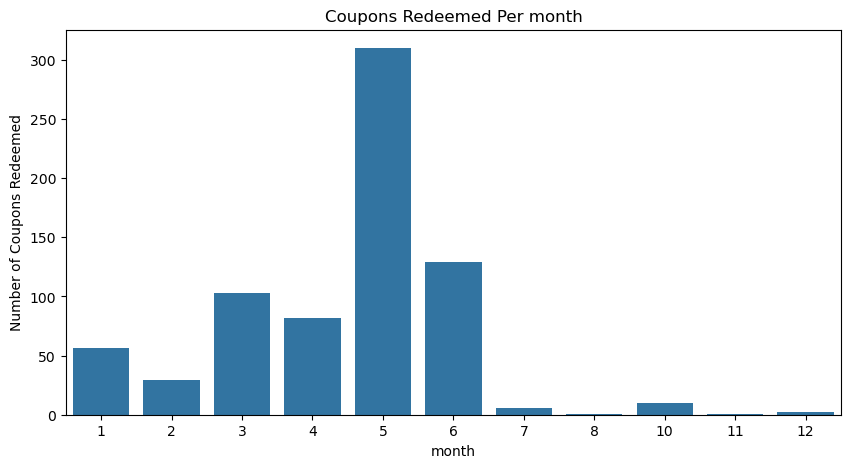

In [208]:
# finding datas where redemption_status=1 
redeemed = train[train['redemption_status'] == 1]

# plotting graph for redeemed coupons per month
redeemed_per_day = redeemed.groupby('month')['coupon_id'].count().reset_index(name='redeemed_count')

plt.figure(figsize=(10,5))
sns.barplot(data=redeemed_per_day, x='month', y='redeemed_count')
plt.title('Coupons Redeemed Per month')
plt.xlabel('month')
plt.ylabel('Number of Coupons Redeemed')
plt.show()

Coupon was most redeemed in 5th month of year , i.e . may .
As we see the trend, coupon remption is lower in starting months and then increases and then further decreases in last months. 
This suggests that coupon redemption may depends on season .


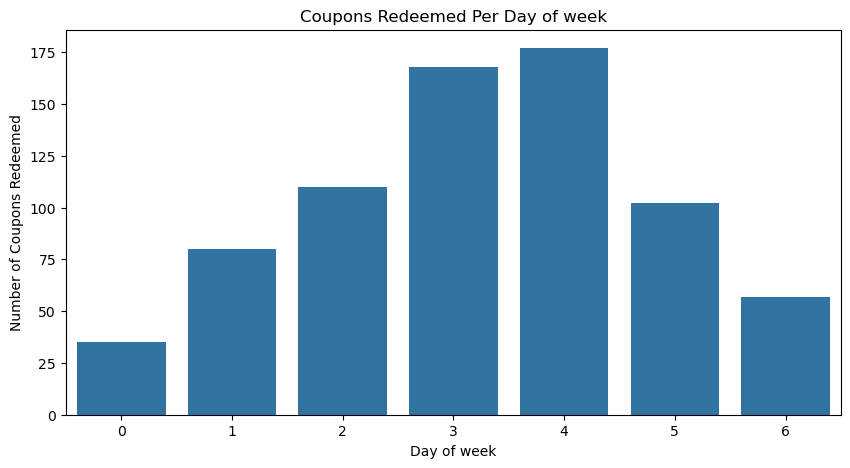

In [210]:
# finding datas where redemption_status=1 
redeemed = train[train['redemption_status'] == 1]

# plotting graph for redeemed coupons per day of week
redeemed_per_day = redeemed.groupby('dow')['coupon_id'].count().reset_index(name='redeemed_count')

plt.figure(figsize=(10,5))
sns.barplot(data=redeemed_per_day, x='dow', y='redeemed_count')
plt.title('Coupons Redeemed Per Day of week')
plt.xlabel('Day of week')
plt.ylabel('Number of Coupons Redeemed')
plt.show()

This shows that coupon was most redeemed on day 3 and day 4 i.e wednesday and thursday.
coupon redemption increases and on reaching , it decreases further.

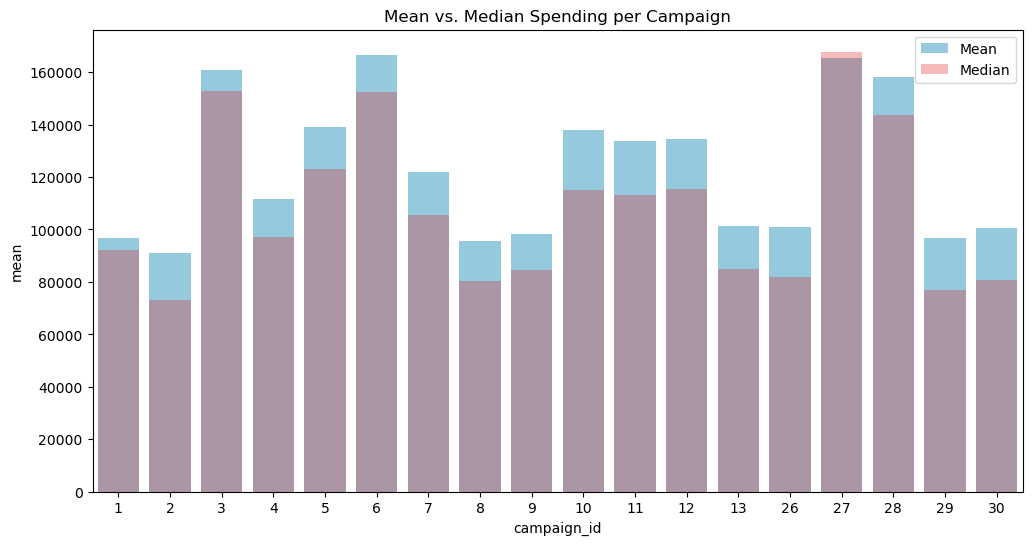

In [212]:
#plotting the spending of customers per campaign_id , based on mean and median
campaign_stats = train.groupby('campaign_id')['total_spending'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=campaign_stats, x='campaign_id', y='mean', color='skyblue', label='Mean')
sns.barplot(data=campaign_stats, x='campaign_id', y='median', color='red', alpha=0.3, label='Median')
plt.title("Mean vs. Median Spending per Campaign")
plt.legend()
plt.show()

The above graph shows that for campaign 27 median > mean spending , and for rest all ids mean> median spending .
This means for campaign 27 , total_spending distribution is left skewed and for other campaign it is right skewed.
For campaign 27, it might be possible that discount for this campaign is more than other campaigns, leading to more purchase . For other campaigns , as mean > median , this means some purchase was of high prie.

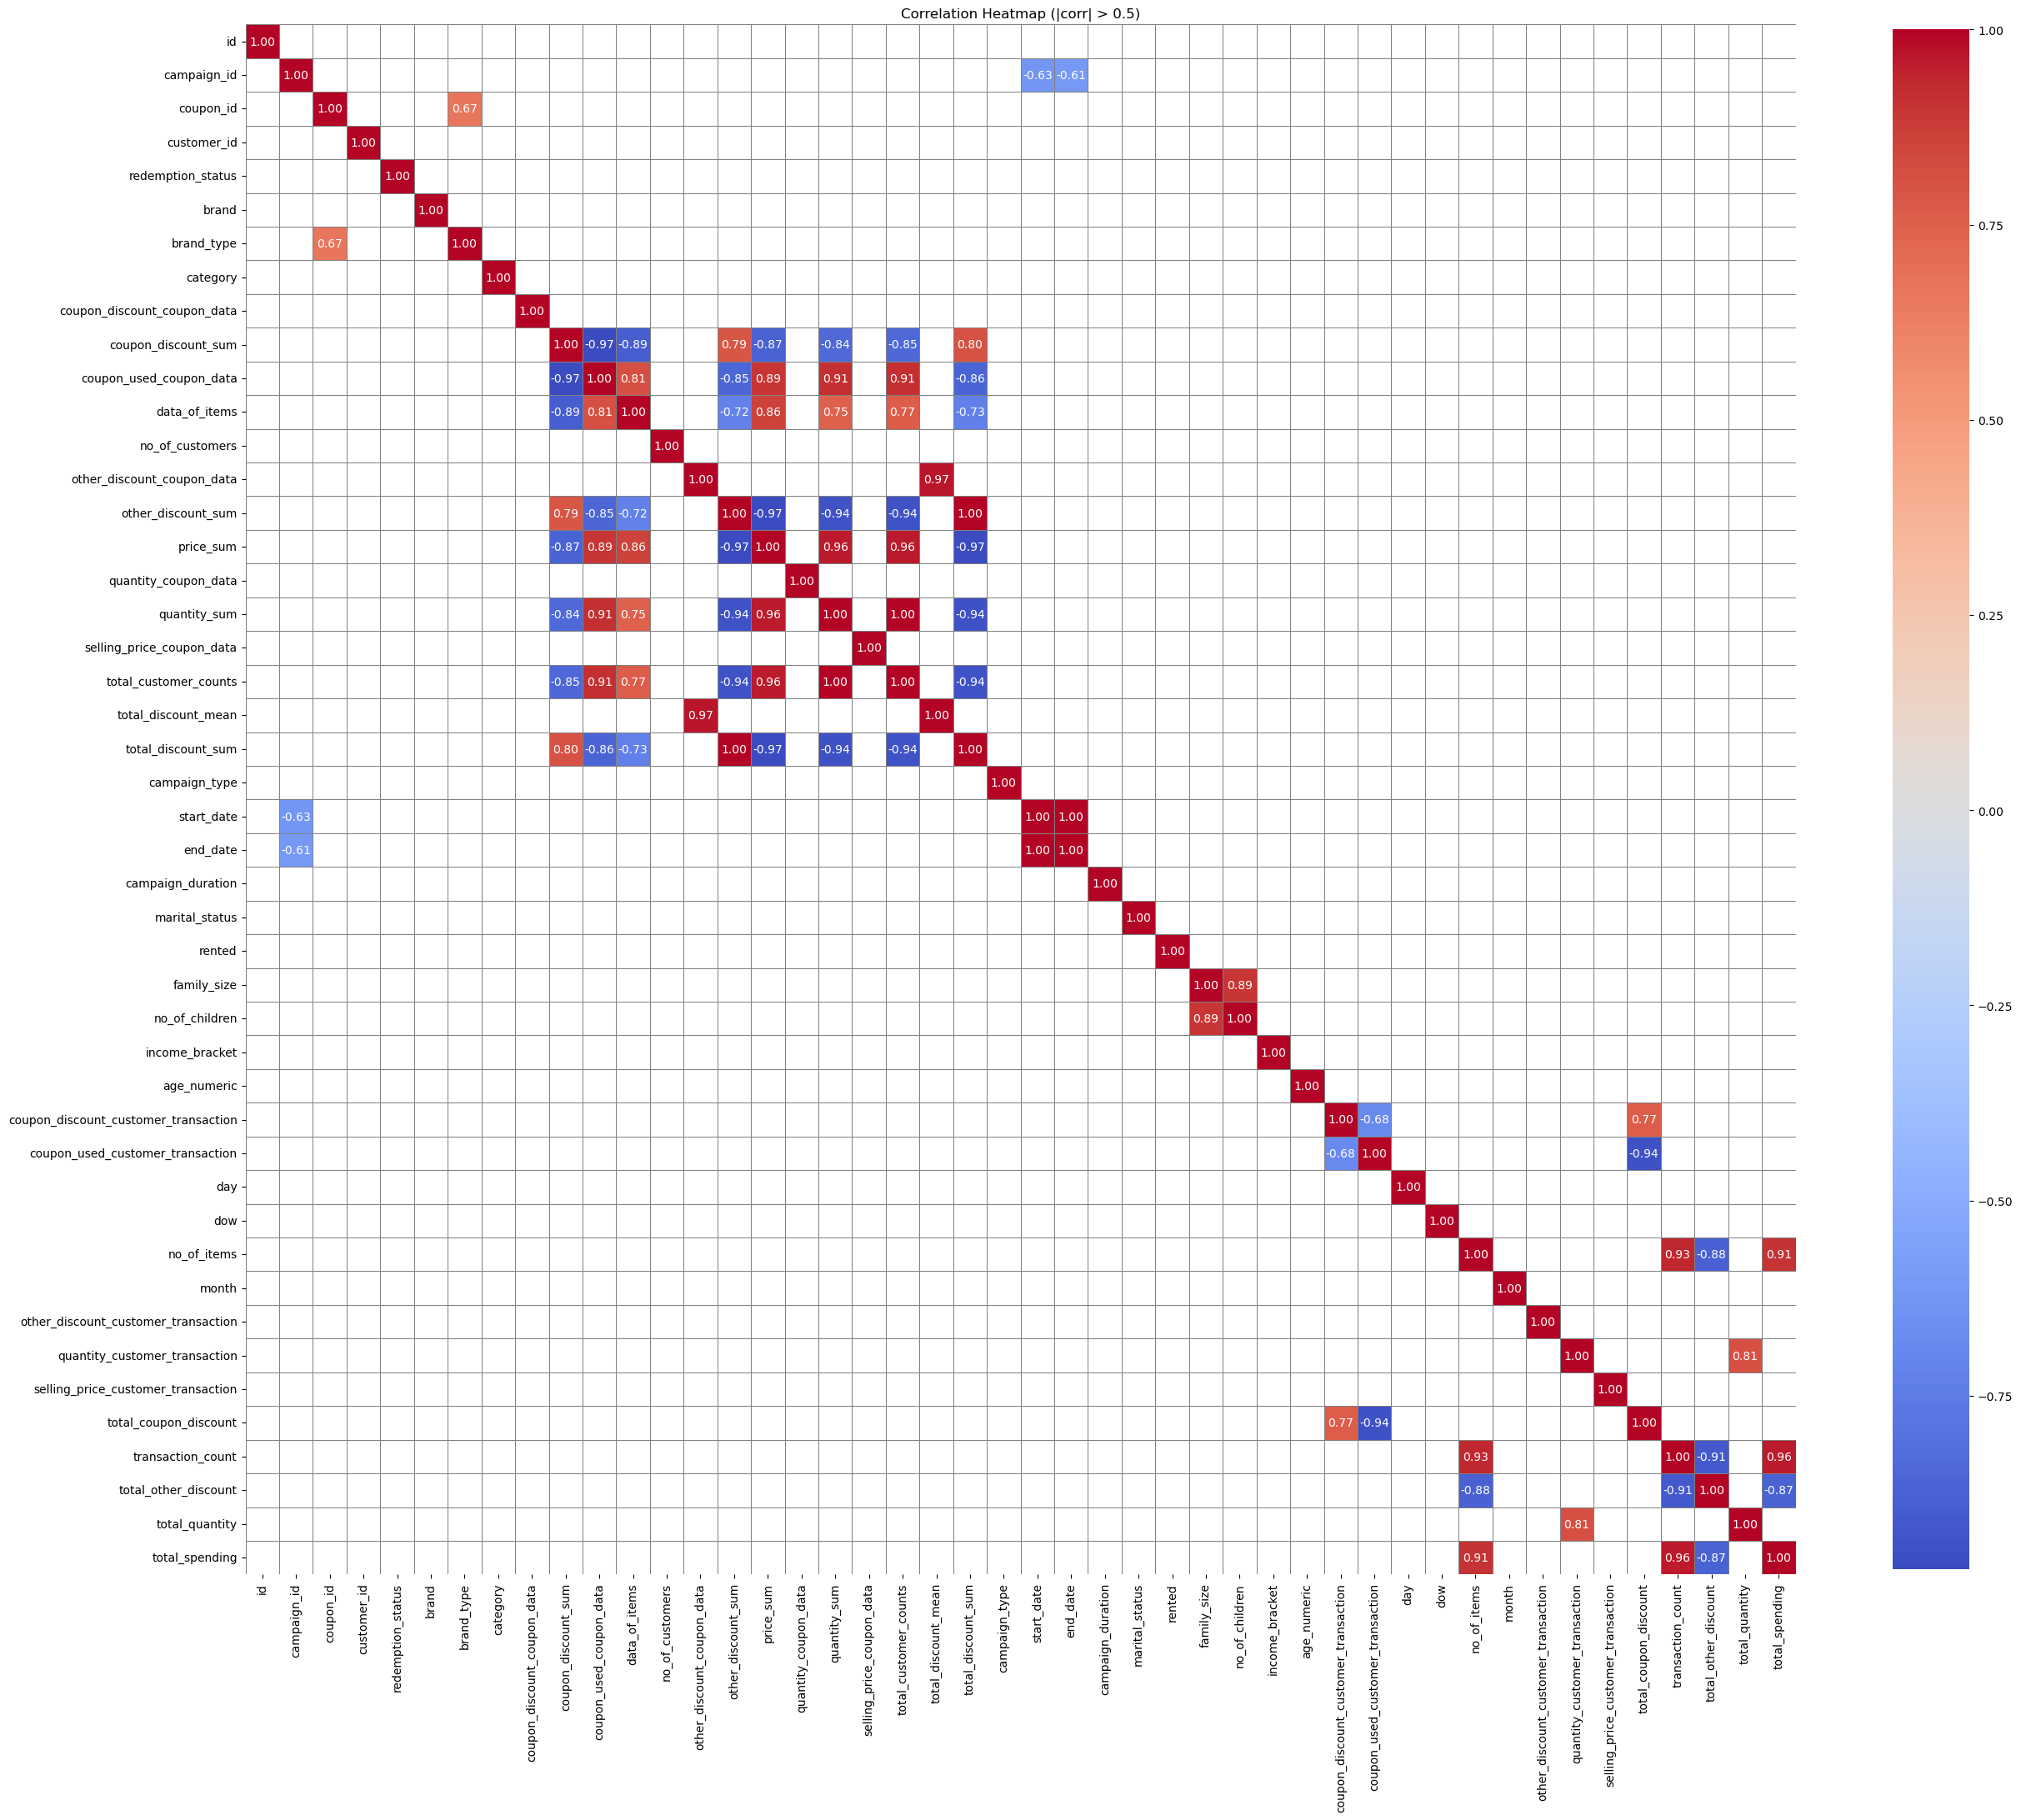

In [214]:
# below heatmap shows correlation between variables, where absolute f correlation > 0.5
corr = train.corr()
mask = (corr.abs() <= 0.5)

filtered_corr = corr.mask(mask)

plt.figure(figsize=(30,30))
sns.heatmap(filtered_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink':0.8}, linewidths=0.5, linecolor='gray')
plt.title('Correlation Heatmap (|corr| > 0.5)')
plt.show()

Building benchmark model

In [216]:
#dropping unwanted columns
test_id = test['id']
target = train['redemption_status']
train.drop(['id','campaign_id','start_date','end_date', 'redemption_status'], axis=1, inplace=True)
test.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [217]:
train.head()

,coupon_id,customer_id,brand,brand_type,category,coupon_discount_coupon_data,coupon_discount_sum,coupon_used_coupon_data,data_of_items,no_of_customers,...,no_of_items,month,other_discount_customer_transaction,quantity_customer_transaction,selling_price_customer_transaction,total_coupon_discount,transaction_count,total_other_discount,total_quantity,total_spending
0,27,1053,1105,1,6,-1.233750,-5221.70,185.0,125,19.224000,...,208,5,-25.583099,340.487097,163.966826,-89.05,310,-7930.760842,105551,50829.715972
1,116,48,56,0,6,0.000000,0.00,0.0,3,20.333333,...,244,6,-19.871924,31.619792,188.703939,-1237.79,384,-7630.818702,12142,72462.312434
2,635,205,560,1,11,-2.987321,-605.54,15.0,67,1.761194,...,533,3,-12.864230,1.392157,112.055027,-2101.20,969,-12465.439143,1349,108581.321349
3,644,1050,611,1,6,-4.452500,-17.81,1.0,4,3.500000,...,216,8,-12.880868,1.291139,100.896997,-178.10,237,-3052.765833,306,23912.588333
4,1017,1489,1558,1,6,-0.155422,-427.44,19.0,32,27.312500,...,327,5,-12.264174,247.443060,85.016352,-265.01,562,-6892.466021,139063,47779.189609


In [218]:
train.shape

(78369, 41)

In [219]:
test.head()

,coupon_id,customer_id,brand,brand_type,category,coupon_discount_coupon_data,coupon_discount_sum,coupon_used_coupon_data,data_of_items,no_of_customers,...,no_of_items,month,other_discount_customer_transaction,quantity_customer_transaction,selling_price_customer_transaction,total_coupon_discount,transaction_count,total_other_discount,total_quantity,total_spending
0,869,967,1075,1,6,-0.716722,-1941.26,50.0,72,20.402778,...,658,5,-10.601140,12.236029,116.043363,-2040.62,1360,-14417.550230,16641,157818.973491
1,389,1566,57,1,11,-1.899476,-1154.03,34.0,33,13.181818,...,1214,6,-9.849175,106.124014,95.906743,-1489.97,2661,-26208.653622,282396,255207.843989
2,981,510,1335,1,6,-0.685403,-2375.90,103.0,19,38.368421,...,1019,5,-16.906480,111.274065,84.492212,-2087.32,1631,-27574.468936,181488,137806.797597
3,1069,361,1996,1,6,-0.889644,-1209.18,43.0,74,18.743243,...,323,6,-11.656451,38.736475,88.203999,0.00,573,-6679.146538,22196,50540.891161
4,498,811,209,1,6,-4.832059,-1711.54,83.0,18,19.444444,...,720,6,-11.466887,1.312024,85.471197,-89.04,1314,-15067.489333,1724,112309.152583


In [220]:
test.shape

(50226, 41)

In [221]:
#splitting data
x_train,x_test,y_train,y_test = train_test_split(train,target,test_size=0.3,random_state=42)

In [222]:
 x_train.shape,y_train.shape,x_test.shape,y_test.shape

((54858, 41), (54858,), (23511, 41), (23511,))

As we need to predict coupon redemption , i.e. 0 and 1 , so it is a classification problem.
So, I am considering models:
1. Logistic Regression
2. Polynomial Logistic Regression
3. KNN
4. Decision tree
5. Random Forest Tree

Logistic Regression

As for logistic regression , we need to apply standardization, as features are not in same scale.

In [226]:
# Create the pipeline
logistic_pipeline = make_pipeline(
    StandardScaler(),                         
    LogisticRegression(random_state=42)
)

In [227]:
logistic_pipeline.fit(x_train, y_train)
y_pred = logistic_pipeline.predict(x_test)

y_pred_proba = logistic_pipeline.predict_proba(x_test)[:, 1]

print(logistic_pipeline.score(x_train, y_train) ) 
print(logistic_pipeline.score(x_test, y_test) )

0.9903569215064348
0.9917910765173749


In [228]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               23313                   2
Actual Positive                 191                   5



AUC-ROC Score: 0.8636


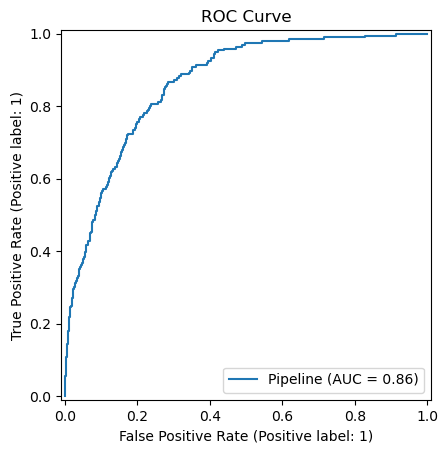

In [229]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(logistic_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [230]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23315
           1       0.71      0.03      0.05       196

    accuracy                           0.99     23511
   macro avg       0.85      0.51      0.52     23511
weighted avg       0.99      0.99      0.99     23511



From the above analyis, we infer : 
Model predicts the majority calss (0) well, but as data is highly imbalanced, it is not able to predict class 1 accurately.

In [232]:
#applying class weight
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticReg', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

In [233]:
logistic_pipeline.fit(x_train, y_train)
y_pred = logistic_pipeline.predict(x_test)

y_pred_proba = logistic_pipeline.predict_proba(x_test)[:, 1]

print(logistic_pipeline.score(x_train, y_train) ) 
print(logistic_pipeline.score(x_test, y_test) )

0.8102008822778811
0.8129386244736506


In [234]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               18964                4351
Actual Positive                  47                 149



AUC-ROC Score: 0.8714


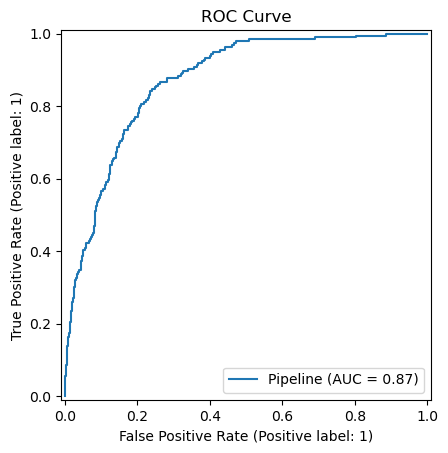

In [235]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(logistic_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [236]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     23315
           1       0.03      0.76      0.06       196

    accuracy                           0.81     23511
   macro avg       0.52      0.79      0.48     23511
weighted avg       0.99      0.81      0.89     23511



Model recall has been improved from 0.3% to 76%, but precision is reduced.
Model accuracy has also reduced.


Polyomial Logistic Regression

In [239]:
poly_logreg_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=100, random_state=42))
])

In [240]:
poly_logreg_pipeline.fit(x_train, y_train)
y_pred = poly_logreg_pipeline.predict(x_test)

y_pred_proba = poly_logreg_pipeline.predict_proba(x_test)[:, 1]

print(poly_logreg_pipeline.score(x_train, y_train) ) 
print(poly_logreg_pipeline.score(x_test, y_test) )

C:\Users\kaurd\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9910860767800503
0.9908978775892135


In [241]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               23289                  26
Actual Positive                 188                   8



AUC-ROC Score: 0.8901


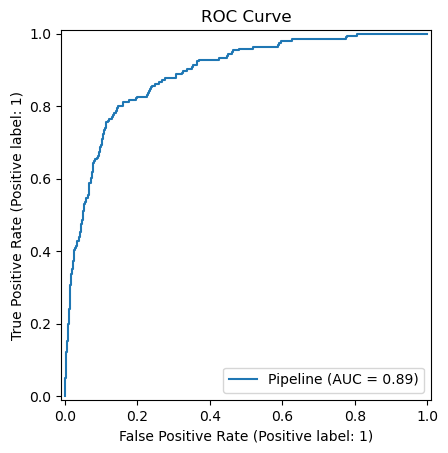

In [242]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(poly_logreg_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [243]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23315
           1       0.24      0.04      0.07       196

    accuracy                           0.99     23511
   macro avg       0.61      0.52      0.53     23511
weighted avg       0.99      0.99      0.99     23511



Though auc roc score has increased, but model is not able to predict class 1 well, as we can see this from classification report

KNN

In [246]:
# Create the pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),           
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [247]:
knn_pipeline.fit(x_train, y_train)
y_pred = knn_pipeline.predict(x_test)
y_pred_proba = knn_pipeline.predict_proba(x_test)[:, 1]
print(knn_pipeline.score(x_train, y_train) ) 
print(knn_pipeline.score(x_test, y_test) )

0.9911589923074119
0.9911105440006805


In [248]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               23301                  14
Actual Positive                 195                   1



AUC-ROC Score: 0.6601


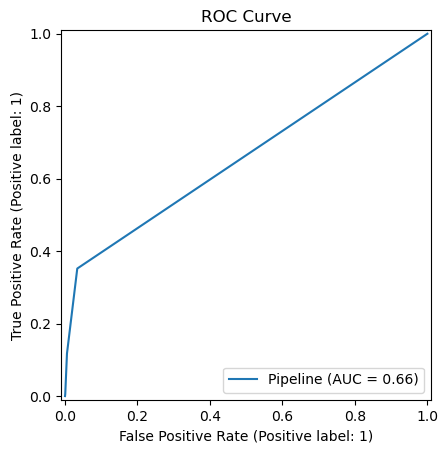

In [249]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(knn_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [250]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23315
           1       0.07      0.01      0.01       196

    accuracy                           0.99     23511
   macro avg       0.53      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



For KNN, AUC ROC score is very less, and also model is not able to predict class 1.
Changing n_neighbours, let's see if model can perform well or not.

In [252]:
neighbors_list = [1, 3, 5, 7, 9, 11, 13, 15]
for k in neighbors_list:
    # Create pipeline for each k
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    knn_pipeline.fit(x_train, y_train)
    
    y_pred = knn_pipeline.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"n_neighbors = {k}: Test Accuracy = {acc:.4f}, AUC-ROC = {auc:.4f}")

n_neighbors = 1: Test Accuracy = 0.9853, AUC-ROC = 0.6601
n_neighbors = 3: Test Accuracy = 0.9897, AUC-ROC = 0.6601
n_neighbors = 5: Test Accuracy = 0.9911, AUC-ROC = 0.6601
n_neighbors = 7: Test Accuracy = 0.9914, AUC-ROC = 0.6601
n_neighbors = 9: Test Accuracy = 0.9916, AUC-ROC = 0.6601
n_neighbors = 11: Test Accuracy = 0.9916, AUC-ROC = 0.6601
n_neighbors = 13: Test Accuracy = 0.9917, AUC-ROC = 0.6601
n_neighbors = 15: Test Accuracy = 0.9917, AUC-ROC = 0.6601


As we see that model auc roc score remains constant for all neighbours , so KNN is not the best model for this dataset

Decision Tree Classifier

For tree-based models , we are not required to do standardisation

In [256]:
decision_tree_pipeline = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [257]:
decision_tree_pipeline.fit(x_train, y_train)
y_pred = decision_tree_pipeline.predict(x_test)
y_pred_proba = decision_tree_pipeline.predict_proba(x_test)[:, 1]
print(decision_tree_pipeline.score(x_train, y_train) ) 
print(decision_tree_pipeline.score(x_test, y_test) )

1.0
0.9823486878482413


In [258]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               23062                 253
Actual Positive                 162                  34



AUC-ROC Score: 0.5813


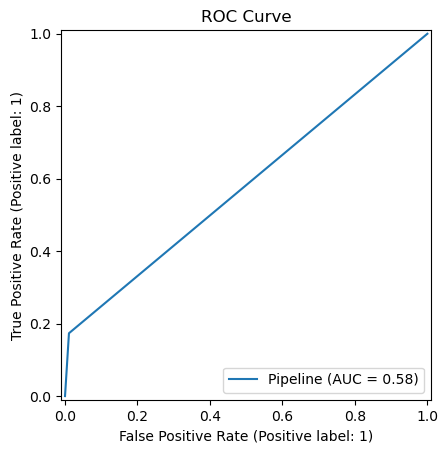

In [259]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(decision_tree_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [260]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23315
           1       0.12      0.17      0.14       196

    accuracy                           0.98     23511
   macro avg       0.56      0.58      0.57     23511
weighted avg       0.99      0.98      0.98     23511



The auc roc score for this model is 58%, which is not at all good, so trying for different model

Random Forest Classifier

In [263]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])

In [264]:
rf_pipeline.fit(x_train, y_train)
y_pred = rf_pipeline.predict(x_test)
y_pred_proba = rf_pipeline.predict_proba(x_test)[:, 1]
print(rf_pipeline.score(x_train, y_train) ) 
print(rf_pipeline.score(x_test, y_test) )


1.0
0.9915784101059079


In [265]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               23307                   8
Actual Positive                 190                   6



AUC-ROC Score: 0.8692


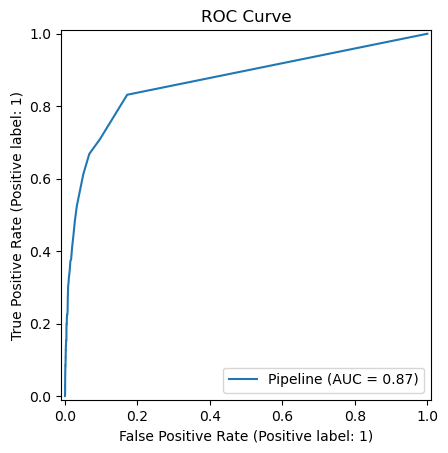

In [266]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(rf_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [267]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23315
           1       0.43      0.03      0.06       196

    accuracy                           0.99     23511
   macro avg       0.71      0.52      0.53     23511
weighted avg       0.99      0.99      0.99     23511



auc roc score is 86% , but still as per confusion matrix , model is not able to predict class 1 well. And so the recall and f1 score is alo less.

As we see from above all algorithms we are not able to cross threshold for auc roc score =0.89 , so let's try for cross validation technique.

Applying cross validation

In [271]:
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    'poly_logreg_pipeline' : Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=100, random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ]),
    'Decision Tree': Pipeline([
        ('dt', DecisionTreeClassifier(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    # 'XGBoost': Pipeline([
    #     ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42))
    # ])
}
pipelines

{'Logistic Regression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('logreg',
                  LogisticRegression(class_weight='balanced', max_iter=1000,
                                     random_state=42))]),
 'poly_logreg_pipeline': Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                 ('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(random_state=42))]),
 'KNN': Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
 'Decision Tree': Pipeline(steps=[('dt', DecisionTreeClassifier(random_state=42))]),
 'Random Forest': Pipeline(steps=[('rf',
                  RandomForestClassifier(class_weight='balanced',
                                         random_state=42))])}

In [272]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model using cross-validation on AUC-ROC
results = {}

for name, pipeline in pipelines.items():
    print(f"Evaluating: {name}")
    scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    results[name] = scores
    print(f"Mean AUC-ROC: {np.mean(scores):.4f} ± {np.std(scores):.4f}\n")
    

Evaluating: Logistic Regression
Mean AUC-ROC: 0.8891 ± 0.0068

Evaluating: poly_logreg_pipeline
Mean AUC-ROC: 0.8908 ± 0.0156

Evaluating: KNN
Mean AUC-ROC: 0.7043 ± 0.0213

Evaluating: Decision Tree
Mean AUC-ROC: 0.5952 ± 0.0177

Evaluating: Random Forest
Mean AUC-ROC: 0.8659 ± 0.0175



As we see from above , logistic regression , polynomial logistic regression are close to 89% auc roc score. 
Let's try to increase no. of folds .

In [274]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate each model using cross-validation on AUC-ROC
results = {}

for name, pipeline in pipelines.items():
    print(f"Evaluating: {name}")
    scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    results[name] = scores
    print(f"Mean AUC-ROC: {np.mean(scores):.4f} ± {np.std(scores):.4f}\n")



Evaluating: Logistic Regression
Mean AUC-ROC: 0.8885 ± 0.0173

Evaluating: poly_logreg_pipeline
Mean AUC-ROC: 0.8951 ± 0.0189

Evaluating: KNN
Mean AUC-ROC: 0.7092 ± 0.0395

Evaluating: Decision Tree
Mean AUC-ROC: 0.6020 ± 0.0213

Evaluating: Random Forest
Mean AUC-ROC: 0.8703 ± 0.0230



From above, we observe that logistic regression auc roc score has reduced a bit, but for random forest and polynomial logistic regression it has increased.

As the data is highly imabalanced, let's look for some more models which might work well on imbalanced data.

SVM

For large datsets SVM takes lot of time to predict result and so is very slow, also we can try it with linear kernel, for which below are the results:

In [279]:
svm_pipeline = Pipeline([
      ('scaler', StandardScaler()),
    ('svm', LinearSVC(class_weight='balanced', max_iter=5000, random_state=42))
])

In [280]:
svm_pipeline.fit(x_train, y_train)
y_pred = svm_pipeline.predict(x_test)
y_pred_proba= svm_pipeline.decision_function(x_test)

print(svm_pipeline.score(x_train, y_train) ) 
print(svm_pipeline.score(x_test, y_test) )

0.8046775310802435
0.8087278295266046


In [281]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               18866                4449
Actual Positive                  48                 148



AUC-ROC Score: 0.8691


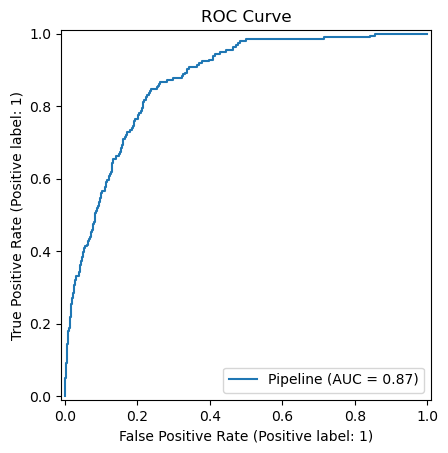

In [282]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(svm_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [283]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     23315
           1       0.03      0.76      0.06       196

    accuracy                           0.81     23511
   macro avg       0.51      0.78      0.48     23511
weighted avg       0.99      0.81      0.89     23511



As we see from above , SVM did not perform well enough , its auc roc score is just 86%.

XGBoost

In [340]:
xgb_pipeline= Pipeline([
   
    ('xgb', XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=77640/729,  
        random_state=42
    ))
])

In [342]:
xgb_pipeline.fit(x_train, y_train)
y_pred = xgb_pipeline.predict(x_test)
y_pred_proba = xgb_pipeline.predict_proba(x_test)[:, 1]
print(xgb_pipeline.score(x_train, y_train) ) 
print(xgb_pipeline.score(x_test, y_test) )

0.9942396733384374
0.9829441538003487


In [344]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               23049                 266
Actual Positive                 135                  61



AUC-ROC Score: 0.9168


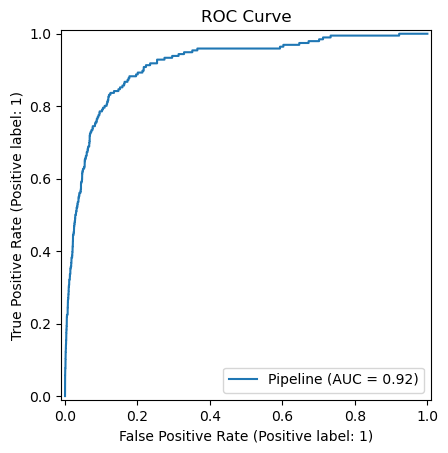

In [346]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(xgb_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [348]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23315
           1       0.19      0.31      0.23       196

    accuracy                           0.98     23511
   macro avg       0.59      0.65      0.61     23511
weighted avg       0.99      0.98      0.99     23511



As we see above, our auc roc score has improved a lot, also precision, recall and f1 has improved on camparing with random forest.
auc roc for this model is good i.e 91%. But precision, recall , F1are still very low.

LightGBM

In [293]:
lgbm_pipeline = Pipeline([
     
    ('lgbm', LGBMClassifier(
       is_unbalance=True,
       random_state=42))
])


In [294]:
lgbm_pipeline.fit(x_train, y_train)
y_pred = lgbm_pipeline.predict(x_test)
y_pred_proba = lgbm_pipeline.predict_proba(x_test)[:, 1]
print(lgbm_pipeline.score(x_train, y_train) ) 
print(lgbm_pipeline.score(x_test, y_test) )

[LightGBM] [Info] Number of positive: 533, number of negative: 54325
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6689
[LightGBM] [Info] Number of data points in the train set: 54858, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009716 -> initscore=-4.624218
[LightGBM] [Info] Start training from score -4.624218
0.976831091180867
0.9687380375143549


In [295]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               22677                 638
Actual Positive                  97                  99



AUC-ROC Score: 0.8975


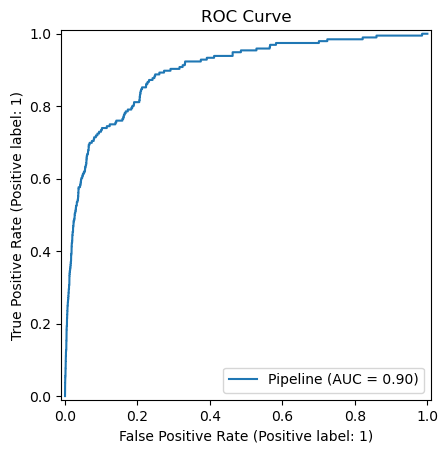

In [296]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(lgbm_pipeline, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [297]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     23315
           1       0.13      0.51      0.21       196

    accuracy                           0.97     23511
   macro avg       0.57      0.74      0.60     23511
weighted avg       0.99      0.97      0.98     23511



In comparison to XGBoost, auc roc score has reduced to 89% for lightGBM, recall has improved but our precision is very low and so F1 score is low.
In comparison to recal xgBoost , recall has increased.

Applying SMOTE

As data is highly imbalaced, using SMOTE technique to handle imbalance data

LightGBM

In [403]:
lgbm_pipeline_smote = Pipeline([
    
  ('smote', SMOTE(random_state=42)),
    
    ('lgbm', LGBMClassifier(
        is_unabalance=True,
        random_state=42,
    class_weight='balanced',))
])


In [405]:
lgbm_pipeline_smote.fit(x_train, y_train)
y_pred = lgbm_pipeline_smote.predict(x_test)
y_pred_proba = lgbm_pipeline_smote.predict_proba(x_test)[:, 1]
print(lgbm_pipeline_smote.score(x_train, y_train) ) 
print(lgbm_pipeline_smote.score(x_test, y_test) )

[LightGBM] [Warning] Unknown parameter: is_unabalance
[LightGBM] [Warning] Unknown parameter: is_unabalance
[LightGBM] [Info] Number of positive: 54325, number of negative: 54325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8226
[LightGBM] [Info] Number of data points in the train set: 108650, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: is_unabalance
[LightGBM] [Warning] Unknown parameter: is_unabalance
[LightGBM] [Warning] Unknown parameter: is_unabalance
0.9876043603485363
[LightGBM] [Warning] Unknown parameter: is_unabalance
0.9835821530347497


In [406]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               23072                 243
Actual Positive                 143                  53



AUC-ROC Score: 0.9142
[LightGBM] [Warning] Unknown parameter: is_unabalance


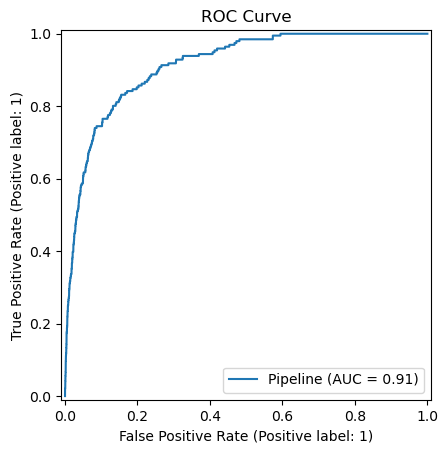

In [409]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(lgbm_pipeline_smote, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [411]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23315
           1       0.18      0.27      0.22       196

    accuracy                           0.98     23511
   macro avg       0.59      0.63      0.60     23511
weighted avg       0.99      0.98      0.99     23511



XgBoost

In [414]:
xgb_pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=77640/729,  
        random_state=42
    ))
])

In [416]:
xgb_pipeline_smote.fit(x_train, y_train)
y_pred = xgb_pipeline_smote.predict(x_test)
y_pred_proba = xgb_pipeline_smote.predict_proba(x_test)[:, 1]
print(xgb_pipeline_smote.score(x_train, y_train) ) 
print(xgb_pipeline_smote.score(x_test, y_test) )

0.9895001640599366
0.9740972310833227


In [418]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Negative', 'Actual Positive'],
                    columns=['Predicted Negative', 'Predicted Positive'])
print("\nLabeled Confusion Matrix:")
print(cm_df)


Labeled Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               22832                 483
Actual Positive                 126                  70



AUC-ROC Score: 0.8929


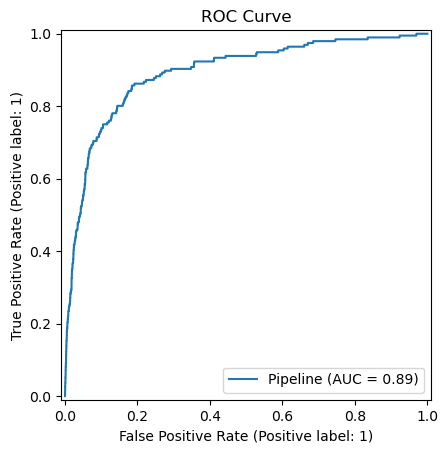

In [420]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(xgb_pipeline_smote, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [422]:
# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     23315
           1       0.13      0.36      0.19       196

    accuracy                           0.97     23511
   macro avg       0.56      0.67      0.59     23511
weighted avg       0.99      0.97      0.98     23511



From both XgBoost and LightGBM, auc roc score for lgbm increased on applying SMOTE and for xgboost it decreased.

Applying hyperparameter tuning

In [331]:
# y_pred_test = lgbm_pipeline_smote.predict(test)
# output_df = pd.DataFrame({
#     'id': test_id,
#     'redemption_status': y_pred_test,
    
# })
# output_df.to_csv('output3.csv', index=False)